In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso ,Ridge,RidgeCV

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import optuna
from optuna.samplers import TPESampler

import warnings
warnings.filterwarnings('ignore')
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
import pandas as pd 
import numpy as np 
from factor_analyzer import FactorAnalyzer, calculate_bartlett_sphericity, calculate_kmo
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.decomposition import PCA

In [2]:
## Set these to TRUE if you want to tune the models again. 
RETUNE_CATBOOST = False
RETUNE_LGBM = False
RETUNE_LASSO = False

In [3]:
train = pd.read_csv('playground-series-s4e10/train.csv', index_col=0)
test = pd.read_csv('playground-series-s4e10/test.csv', index_col=0)
original = pd.read_csv('playground-series-s4e10/credit_risk_dataset.csv')


df = pd.concat([train, original])
df2 = pd.concat([train, original])

In [4]:
df.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
loan_status                      0
dtype: int64

From this we can noticed that there are null values in person_emp_length and loan_int_rate which are 895 and 3,116.

In [5]:
import pandas as pd
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df2= df2.dropna()
df2 = df2.select_dtypes(include=[float, int])
# Calculate the KMO score
df2 = pd.get_dummies(df2, drop_first=True)
df2 = df2.fillna(df2.mean())
standardized_data = scaler.fit_transform(df2)
# Drop redundant variable (e.g., cb_person_cred_hist_length or person_age)
df2 = df2.drop(['cb_person_cred_hist_length'], axis=1)

# Standardize the dataset
scaler = StandardScaler()
data_standardized = scaler.fit_transform(df2)
# Convert back to DataFrame for KMO calculation
data_standardized_df = pd.DataFrame(data_standardized, columns=df2.columns)
# Calculate KMO
kmo_all, kmo_model = calculate_kmo(data_standardized_df)
print(f"Updated KMO Model Score: {kmo_model}")



Updated KMO Model Score: 0.3910714396271017


Kaiser-Meyer-Olkin (KMO) is to measure how well the variables in the datasets relate to each other through the underlying factor. Hence, the higher value of KMO indicates the factor analysis is more towards the sampling adequacy. High KMO values suggest that correlations are large relative to partial correlations, indicating that the variables share a common factor structure. However, in our model, the KMO test is less than 0.5, which means it is not suitable for factor analysis. This may happen if the correlations among variables are weak, and the partial correlations are high, suggesting a lack of underlying common factors.

In [6]:
df2.corr()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,loan_status
person_age,1.000000,0.134078,0.136925,0.052171,0.010858,-0.034594,-0.008152
person_income,0.134078,1.000000,0.148089,0.285246,-0.029506,-0.260743,-0.150105
person_emp_length,0.136925,0.148089,1.000000,0.099156,-0.085159,-0.061190,-0.092210
loan_amnt,0.052171,0.285246,0.099156,1.000000,0.127194,0.620457,0.135166
loan_int_rate,0.010858,-0.029506,-0.085159,0.127194,1.000000,0.143614,0.341812
loan_percent_income,-0.034594,-0.260743,-0.061190,0.620457,0.143614,1.000000,0.381352
loan_status,-0.008152,-0.150105,-0.092210,0.135166,0.341812,0.381352,1.000000


In [7]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91226 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  91226 non-null  int64  
 1   person_income               91226 non-null  int64  
 2   person_home_ownership       91226 non-null  object 
 3   person_emp_length           90331 non-null  float64
 4   loan_intent                 91226 non-null  object 
 5   loan_grade                  91226 non-null  object 
 6   loan_amnt                   91226 non-null  int64  
 7   loan_int_rate               88110 non-null  float64
 8   loan_percent_income         91226 non-null  float64
 9   cb_person_default_on_file   91226 non-null  object 
 10  cb_person_cred_hist_length  91226 non-null  int64  
 11  loan_status                 91226 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 9.0+ MB


This is to demonstrate the contents of our datasets. For instance, the data type of each variable and the quantity of non-empty numbers in the particular variable.

In [9]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,91226.000000,9.122600e+04,90331.000000,91226.000000,88110.000000,91226.000000,91226.000000,91226.000000
mean,27.616480,6.477071e+04,4.732119,9350.348607,10.789508,0.163154,5.810219,0.169447
std,6.148115,4.793696e+04,4.025068,5848.605423,3.108998,0.097491,4.038412,0.375149
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,23.000000,4.000000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,26.000000,5.700000e+04,4.000000,8000.000000,10.950000,0.140000,4.000000,0.000000
75%,30.000000,7.800000e+04,7.000000,12000.000000,13.110000,0.220000,8.000000,0.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [10]:
df['loan_status'].value_counts(normalize=True)

loan_status
0    0.830553
1    0.169447
Name: proportion, dtype: float64

The likelihood that the lender will successfully obtain the loan is zero. On the other hand, 1 represents the likelihood that the lender will not receive their loan.

In [11]:
df.dtypes

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
loan_status                     int64
dtype: object

This indicates what types of datasets is used in every variables in our datasets.

In [12]:
df.count()

person_age                    91226
person_income                 91226
person_home_ownership         91226
person_emp_length             90331
loan_intent                   91226
loan_grade                    91226
loan_amnt                     91226
loan_int_rate                 88110
loan_percent_income           91226
cb_person_default_on_file     91226
cb_person_cred_hist_length    91226
loan_status                   91226
dtype: int64

This indicates the quantity of non-empty numbers in the particular variable.

In [13]:
def create_bivariate_plots_numerical(df, target_column):
    
    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    if target_column in numerical_cols:
        numerical_cols.remove(target_column)

    n_rows = len(numerical_cols) 
    fig, axes = plt.subplots(n_rows, 2, figsize=(10, n_rows * 4))


    for i, col in enumerate(numerical_cols):

        sns.histplot(data=df, x=col, hue=target_column, ax=axes[i, 0], kde=True)
        axes[i, 0].set_title(f'{col}')

        sns.boxplot(data=df, y=col, x=target_column, ax=axes[i, 1])
        axes[i, 1].set_title(f'{col}')
    
    plt.tight_layout()
    plt.show()


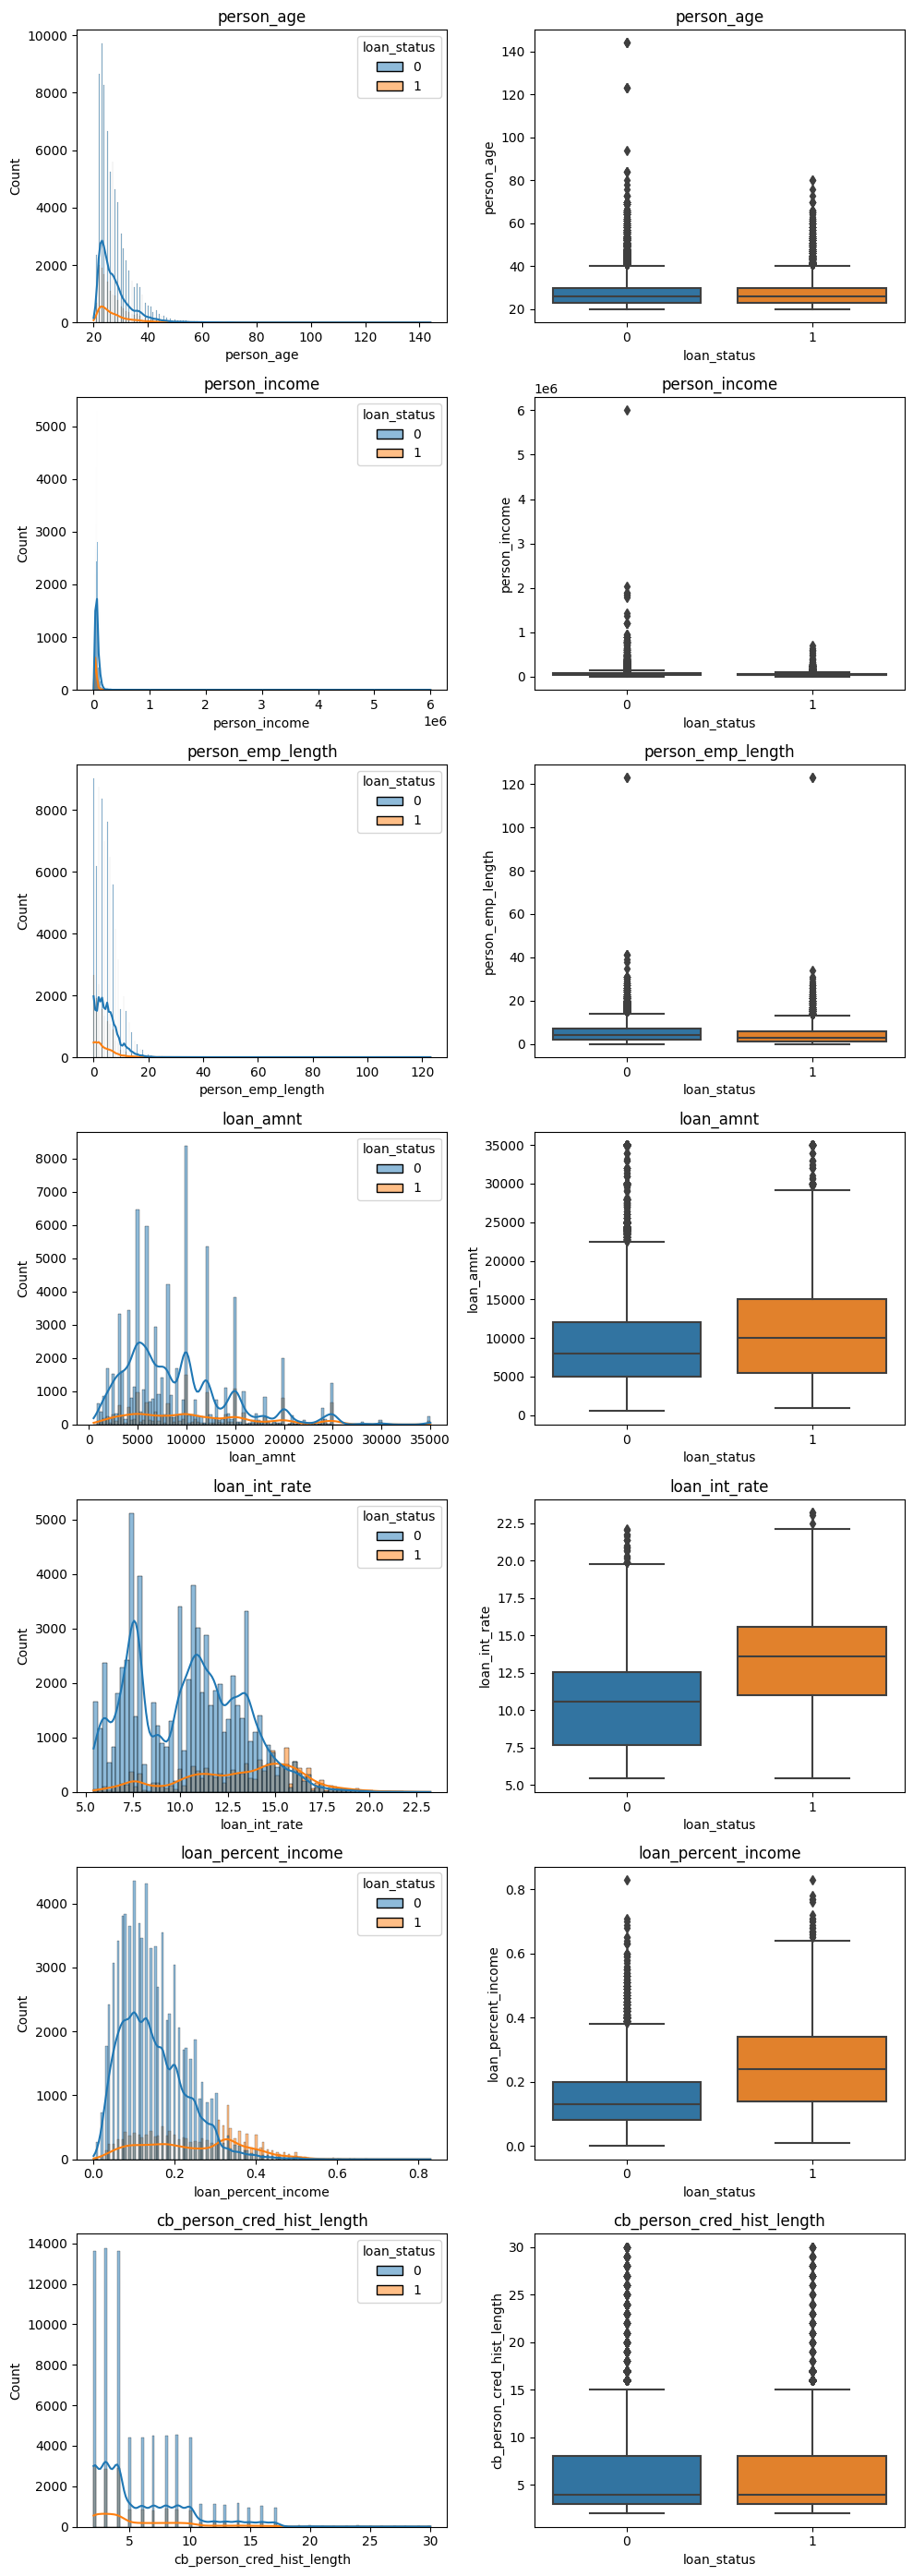

In [14]:
create_bivariate_plots_numerical(df.reset_index(drop=True), 'loan_status')

# **This is before preprocessing datasets.**

The first-row graph indicates the person's age and the number of lenders who successfully got the loan and those who failed to get the loan. The histogram shows that most lenders who successfully got the loan and most lenders who failed to get the loan are in the same group of individuals who are aged 20 to 40. From the boxplot, we can visualize that the older you get which means older than age 80 the more possibility of the lender getting the loan. However, if the lender age is between 20 to 40 the percentage of them getting a loan is 50%. Furthermore, there a outliers who are above 140 years old and get the loans.

The second row of the graph shows the person's yearly income against the number of lenders who successfully got the loan. From the histogram, we can visualize that the majority of the lender's yearly income is less than $1,000,000. We also can see that the number of lenders who successfully got the loan is far more than the ones who failed to get the loan. We can see from the boxplot that some lenders who were successful in obtaining a loan did so with incomes exceeding $6,000,000.  

The third row of the histogram shows the person's employment length against the number of lenders who successfully got the loan. It clearly shows that the shorter the employment length the more possibility the lender will the loan. From the boxplot, we can visualize that the shorter the length of employment length the higher the possibility that the lenders can get the loan the majority of the lenders who successfully have the loan and the majority of the lenders who failed to get the loan are the same group of person which is employment length less than 20. There is also an outlier in the lender who failed to get the loans and has worked for over 120 years.

The fourth row of the histogram shows the total loan amount the lender loans against the number of the lender getting the loan. The histogram shows that the lesser amount the lender loans the possibility of the lender getting the loan is higher. From the boxplot, we can visualize that there are many outliers that loan above 20,000 and successfully get their loan.  

The fifth row of the histogram shows the loan interest against the amount of the lenders that successfully get their loans. From the histogram, we can visualize that an interest rate of 7.5% is the highest amount in the datasets. As the loan interest rate increases the possibility of the lender successfully getting the loan decreases. We can visualize from the boxplot that the more the interest rate the lender has the more possibility that the lender will fail to get the loan higher. 

The sixth row of the histogram shows the loan percent to income against the number of lender who successfully got their loan. We can visualize from the histogram that the highest amount of lenders who successfully got the loan percentage to their income is 0.1, and this group of lenders has the highest possibility of getting the loan they wish to have. On the other hand, the boxplot shows that if the lender's loan is 10% more than their income, the possibility of them failing to get the loan increases. 

The last row of the histogram shows the credit bureau of the lender against the number of lenders who successfully got their loans. We can visualize that the lesser the credit history length of the lender, the higher the possibility that the lender successfully gets the loan is higher. If the lender's credit history length is shorter than 5 the possibility of the lender getting the loan is higher. However, from the boxplot, it seems no difference no matter how long or how short your credit bureau, the chance of getting the loan is 50%.  

In [15]:
def create_bivariate_plots_categorical(df, target_column):
    
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    if target_column in categorical_cols:
        categorical_cols.remove(target_column)

    n_rows = int(np.ceil(len(categorical_cols)/2))  # One row for each numerical column
    fig, axes = plt.subplots(n_rows, 2, figsize=(10, n_rows * 4))

    axes = axes.flatten()
    
    for i, col in enumerate(categorical_cols):
        percentage_df = df.groupby(col)[target_column].mean().sort_values().reset_index()
        percentage_df[target_column] = percentage_df[target_column] * 100  

        # creating bar plots
        sns.barplot(data=percentage_df, x=col, y=target_column, ax = axes[i], palette='viridis')
        axes[i].set_title(f'Percentage of Loan Default by {col}')
        axes[i].set_xticks(axes[i].get_xticks(), axes[i].get_xticklabels(), rotation=45, ha='right')
        axes[i].set_ylabel(f'Loan Default %')
        
    plt.tight_layout()
    plt.show()

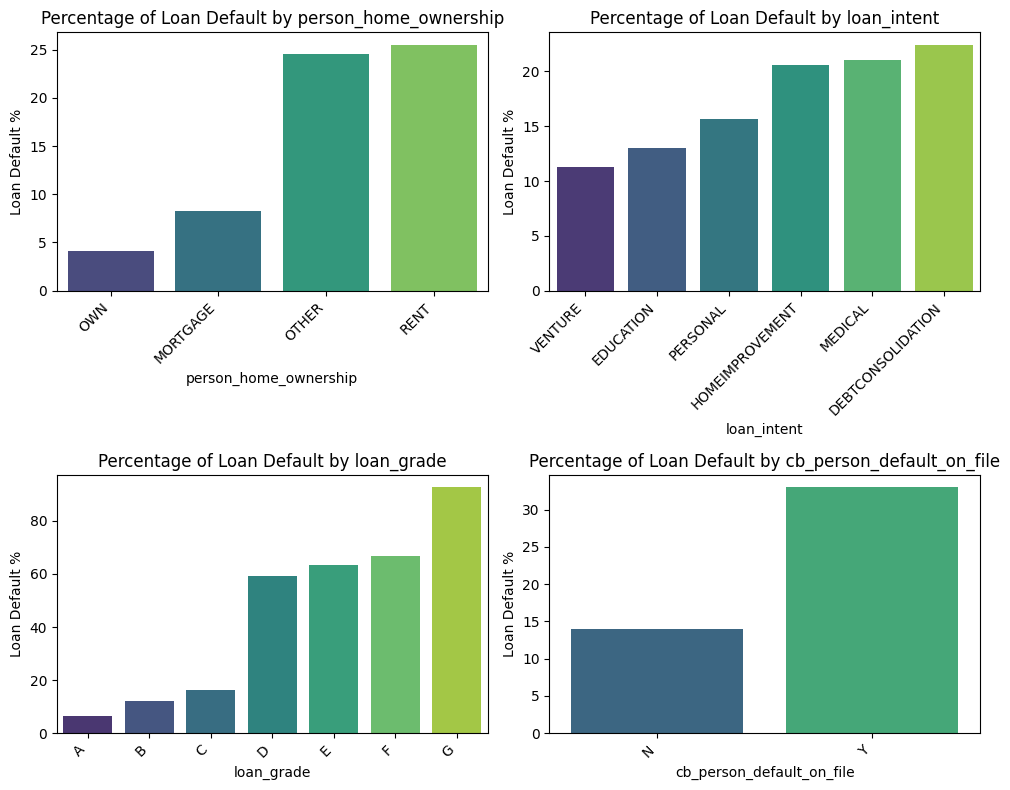

In [16]:
create_bivariate_plots_categorical(df.reset_index(drop=True), 'loan_status')

# **This is before preprocessing datasets.**

The top left corner shows the graph showing the percentage of lenders who failed to have their loan against the lender's personal home ownership. We can visualize from the histogram that if the lender owns a home, the percentage of the lenders who failed to get the loan is less than 5%. However, if the lender does not own any home properties, and they are renting a house the percentage of the lender failing to have the loan is around 25%. 

The top right corner shows the lender loan intention against the percentage of lenders who failed to have their loan. If the lender would like to borrow a loan for venture activities, the percentage of failure to have the loan is very small which is less than 15%. If the lender borrows a loan for debt consolidation the percentage of the lender failing to get the loan is above 20%. 

The bottom left shows the type of lender graded by the bank against the percentage of lenders who failed to have their loan. It follows alphabetic order that grade A lenders have a lower chance of getting rejected by banks. It shows that the grade A who fails to get the loan is less than 10%. Grade G lenders have the highest chance of failing to get the loan which is more than 80%.

The right bottom corner shows the credit bureau of the lender against the percentage of lenders who failed to have their loan. If the lender has a good credit bureau background the percentage of them who fail to have the loan is less than 15%. If the lender has a bad credit bureau background, the percentage of them failing to get the loan is more than 30%.

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class LoanDefaultAnalysis:
    def __init__(self):
        self.numerical_features = [
            'person_age', 'person_income', 'person_emp_length',
            'loan_amnt', 'loan_int_rate', 'loan_percent_income',
            'cb_person_cred_hist_length'
        ]
        
        self.categorical_features = [
            'person_home_ownership', 'loan_intent', 'loan_grade',
            'cb_person_default_on_file'
        ]
        
        # Initialize preprocessor
        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])

        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(drop='first', sparse=False))
        ])

        self.preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, self.numerical_features),
                ('cat', categorical_transformer, self.categorical_features)
            ])
        
    def get_feature_names(self, categorical_features_enc):
        """
        Get feature names after preprocessing
        """
        # Names for numerical features
        feature_names = self.numerical_features.copy()
        
        # Names for categorical features (excluding the first category due to drop='first')
        for i, (feature, categories) in enumerate(zip(self.categorical_features, categorical_features_enc)):
            feature_names.extend([f"{feature}_{cat}" for cat in categories[1:]])
            
        return feature_names
    
    def prepare_data(self, df):
        """
        Prepare data for analysis with proper preprocessing pipeline
        """
        # Create X and y
        X = df[self.numerical_features + self.categorical_features]
        y = df['loan_status']
        
        # Fit preprocessor on all data to get feature names
        X_transformed = self.preprocessor.fit_transform(X)
        
        # Get categorical feature names after encoding
        cat_features_enc = (
            self.preprocessor
            .named_transformers_['cat']
            .named_steps['onehot']
            .categories_
        )
        
        # Store feature names
        self.feature_names = self.get_feature_names(cat_features_enc)
        
        return X, y
    
    def train_models(self, X, y):
        """
        Train both linear and logistic regression models
        """
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Transform the data
        X_train_transformed = self.preprocessor.transform(X_train)
        X_test_transformed = self.preprocessor.transform(X_test)
        
        # Create and train models
        linear_model = LinearRegression()
        logistic_model = LogisticRegression(max_iter=1000)
        
        # Fit models
        linear_model.fit(X_train_transformed, y_train)
        logistic_model.fit(X_train_transformed, y_train)
        
        return {
            'linear': {
                'model': linear_model,
                'X_train_transformed': X_train_transformed,
                'X_test_transformed': X_test_transformed,
                'y_train': y_train,
                'y_test': y_test
            },
            'logistic': {
                'model': logistic_model,
                'X_train_transformed': X_train_transformed,
                'X_test_transformed': X_test_transformed,
                'y_train': y_train,
                'y_test': y_test
            }
        }
    
    def evaluate_models(self, trained_models):
        """
        Evaluate both models and return results
        """
        results = {}
        
        # Linear Regression Evaluation
        linear = trained_models['linear']
        y_pred_linear = linear['model'].predict(linear['X_test_transformed'])
        
        results['linear'] = {
            'mse': mean_squared_error(linear['y_test'], y_pred_linear),
            'r2': r2_score(linear['y_test'], y_pred_linear),
            'feature_importance': pd.DataFrame({
                'Feature': self.feature_names,
                'Coefficient': linear['model'].coef_
            }).sort_values(by='Coefficient', key=abs, ascending=False),
            'y_test': linear['y_test'],
            'y_pred': y_pred_linear
        }
        
        # Logistic Regression Evaluation
        logistic = trained_models['logistic']
        y_pred_logistic = logistic['model'].predict(logistic['X_test_transformed'])
        y_pred_prob = logistic['model'].predict_proba(logistic['X_test_transformed'])
        
        results['logistic'] = {
            'accuracy': accuracy_score(logistic['y_test'], y_pred_logistic),
            'roc_auc': roc_auc_score(logistic['y_test'], y_pred_prob[:, 1]),
            'classification_report': classification_report(logistic['y_test'], y_pred_logistic),
            'feature_importance': pd.DataFrame({
                'Feature': self.feature_names,
                'Coefficient': logistic['model'].coef_[0]
            }).sort_values(by='Coefficient', key=abs, ascending=False),
            'y_test': logistic['y_test'],
            'y_pred': y_pred_logistic,
            'y_pred_prob': y_pred_prob
        }
        
        return results
    
    def visualize_results(self, results):
        """
        Create comprehensive visualizations for both models
        """
        fig = plt.figure(figsize=(20, 15))
        
        # 1. Linear Regression Actual vs Predicted
        ax1 = plt.subplot(321)
        ax1.scatter(results['linear']['y_test'], results['linear']['y_pred'], alpha=0.5)
        ax1.plot([0, 1], [0, 1], 'r--')
        ax1.set_title('Linear Regression: Actual vs Predicted')
        ax1.set_xlabel('Actual Values')
        ax1.set_ylabel('Predicted Values')
        
        # 2. Linear Regression Feature Importance
        ax2 = plt.subplot(322)
        top_features_linear = results['linear']['feature_importance'].head(10)
        sns.barplot(data=top_features_linear, x='Coefficient', y='Feature', ax=ax2)
        ax2.set_title('Top 10 Features (Linear Regression)')
        
        # 3. Logistic Regression ROC Curve
        ax3 = plt.subplot(323)
        fpr, tpr, _ = roc_curve(results['logistic']['y_test'], 
                               results['logistic']['y_pred_prob'][:, 1])
        ax3.plot(fpr, tpr, label=f'ROC curve (AUC = {results["logistic"]["roc_auc"]:.2f})')
        ax3.plot([0, 1], [0, 1], 'k--')
        ax3.set_title('Logistic Regression: ROC Curve')
        ax3.set_xlabel('False Positive Rate')
        ax3.set_ylabel('True Positive Rate')
        ax3.legend()
        
        # 4. Logistic Regression Feature Importance
        ax4 = plt.subplot(324)
        top_features_logistic = results['logistic']['feature_importance'].head(10)
        sns.barplot(data=top_features_logistic, x='Coefficient', y='Feature', ax=ax4)
        ax4.set_title('Top 10 Features (Logistic Regression)')
        
        # 5. Confusion Matrix
        ax5 = plt.subplot(325)
        cm = confusion_matrix(results['logistic']['y_test'], results['logistic']['y_pred'])
        sns.heatmap(cm, annot=True, fmt='d', ax=ax5)
        ax5.set_title('Confusion Matrix')
        ax5.set_xlabel('Predicted')
        ax5.set_ylabel('Actual')
        
        # 6. Probability Distribution
        ax6 = plt.subplot(326)
        sns.histplot(data=results['logistic']['y_pred_prob'][:, 1], bins=50, ax=ax6)
        ax6.set_title('Probability Distribution of Default')
        ax6.set_xlabel('Predicted Probability of Default')
        ax6.set_ylabel('Count')
        
        plt.tight_layout()
        return fig

def main(df):
    """
    Run the complete analysis pipeline
    """
    # Initialize analyzer
    analyzer = LoanDefaultAnalysis()
    
    # Prepare data
    X, y = analyzer.prepare_data(df)
    
    # Train models
    trained_models = analyzer.train_models(X, y)
    
    # Evaluate models
    results = analyzer.evaluate_models(trained_models)
    
    # Create visualizations
    fig = analyzer.visualize_results(results)
    
    return results, fig



Linear Regression Results:
R² Score: 0.345
MSE: 0.091

Logistic Regression Results:
Accuracy: 0.895
ROC AUC: 0.882

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     15196
           1       0.76      0.54      0.63      3050

    accuracy                           0.89     18246
   macro avg       0.84      0.75      0.79     18246
weighted avg       0.89      0.89      0.89     18246



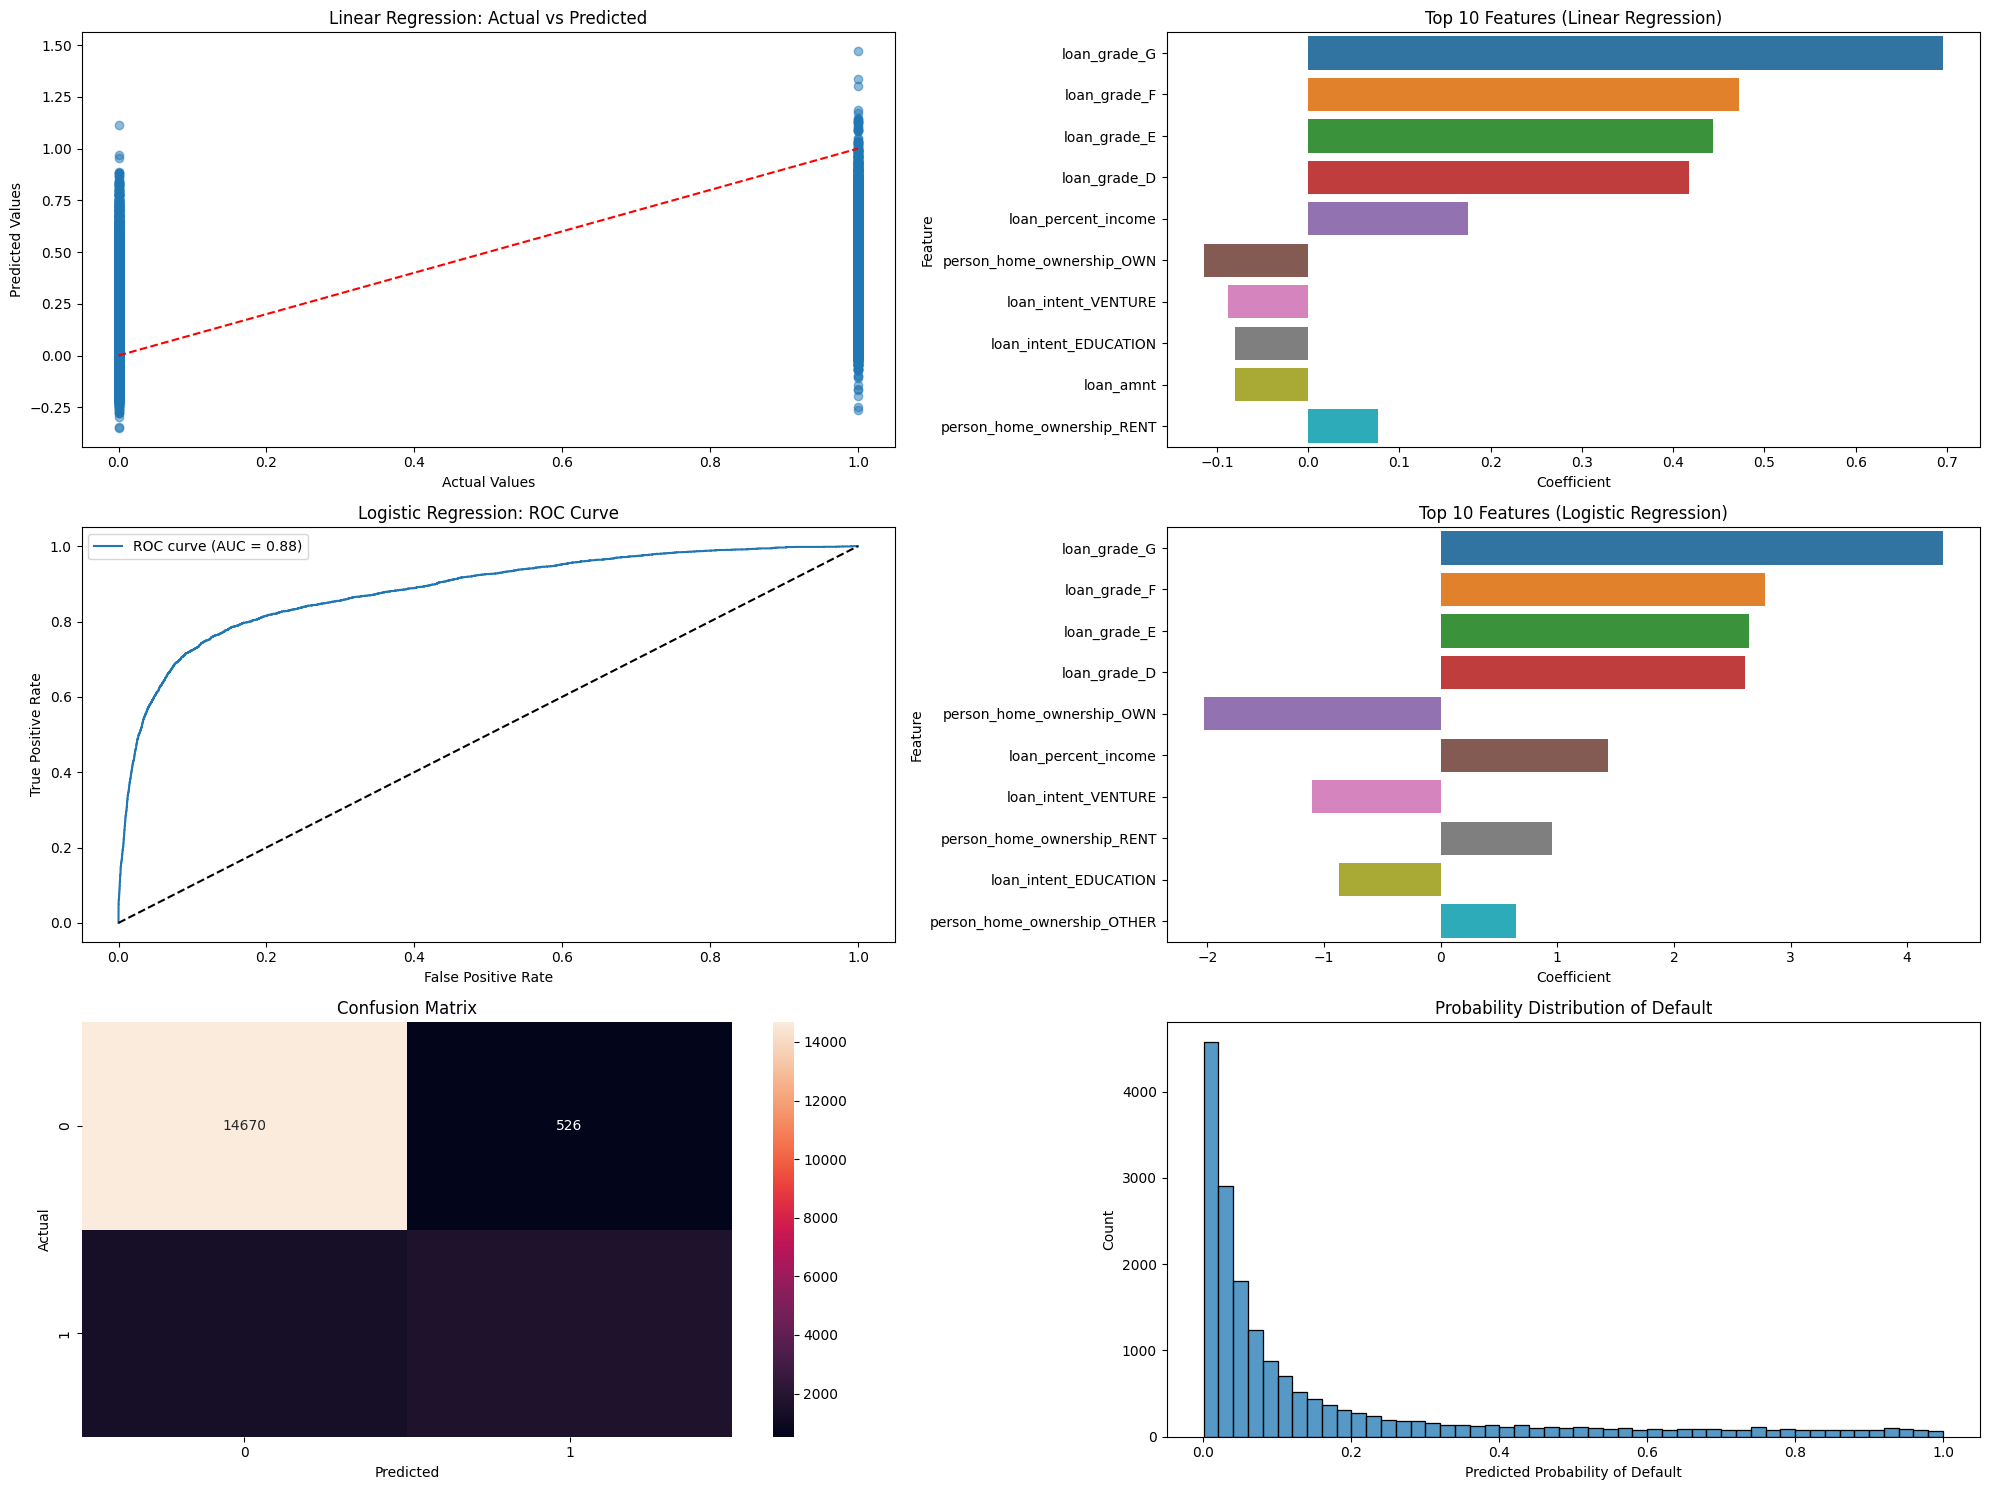

In [18]:
if __name__ == "__main__":
    # Load your data
    
    
    # Run analysis
    results, fig = main(df)

    # Print key metrics
    print("\nLinear Regression Results:")
    print(f"R² Score: {results['linear']['r2']:.3f}")
    print(f"MSE: {results['linear']['mse']:.3f}")
    
    print("\nLogistic Regression Results:")
    print(f"Accuracy: {results['logistic']['accuracy']:.3f}")
    print(f"ROC AUC: {results['logistic']['roc_auc']:.3f}")
    print("\nClassification Report:")
    print(results['logistic']['classification_report'])

# **Linear Regression Results**

The r2 value of this model is 34.5%. This indicates that the variance in loan_status is explained by the input features. This is relatively low, suggesting that the linear regression model struggles to capture the variability in the data.

The MSE value is 0.091. This measures the average squared difference between the predicted and actual values. Since the target variable is binary, the MSE is close to zero, but this doesn't necessarily indicate strong performance.

# **Logistic Regression Model**

The accuracy of the model in training is 89.5%.

The Receiver Operating Characteristic - Area Under Curve (ROC AUC) score of 0.882 indicates that the model performs well in recognizing between the two classes which are success and failure. It reflects a high-quality classification model.

# **Classification Report**

# For Class 0:-

The precision of this class is 91% successful. The high precision indicates the model is more reliable in identifying successful applicants.

The recall of this class is 97% correctly identified actual lenders. This high recall shows the model rarely misses identifying successful loans.

The f1-score of this class is 0.94, indicating that the mean of precision and recall are excellent in performing for class 0.


# For Class 1:-

The precision of this class is 76%. Precision is lower here compared to class 0, indicating more false positives for this class.

The recall of this class is 54% correctly identified the actual failed applicants. This relatively low recall suggests the model struggles to detect all failed applicants.

The f1-score of this class is 0.63, indicating the trade-off between precision and recall for failed applicants.

Macro average is a method of calculating a metric by taking the arithmetic mean of each class's performance metric. It treats all classes equally, regardless of their size or the number of instances. The precision, recall, and f1 score of the macro average are 0.84, 0.75, and 0.79. These are the averages of the precision, recall, and f1 scores across both classes, weighted equally. They provide a balanced view of the model's performance.

Weighted average is a computation that gives each number in a given data set a different level of significance. When every number in a data set is given the same weight, a weighted average may be more accurate than a simple average. The precision, recall, and f1 score of the weighted average are 0.89, 0.89, and 0.89. They are heavily influenced by the larger class 0 because they have a larger weight compared to class 1.

# **Graphical Analysis**

This scatter figure at the top left corner contrasts the predicted values from the linear regression model with the actual loan_status values, which are either 0 or 1. However, the regression model frequently predicts values between 0 and 1, which is less significant for a classification job even though the predictions are clustered around 0 and 1. This binary problem has poor fit and limited predictive power, as evidenced by the large dispersion, particularly at the decision boundary at 0.5.

The top ten characteristics from the linear regression model with the greatest absolute coefficients in the top right corner are displayed in the bar chart. The negative coefficients have a lesser chance of rejection on having a loan, while positive coefficients help have a higher chance of failing to have a loan. Applicants with loan_grade_G are more likely to fail since they have the strongest positive coefficients. Significantly negative coefficients indicate that features like person_home_ownership_OWN lower the likelihood of rejection.

The model's capacity to differentiate between the two classes—loan success and failure—across a range of criteria is demonstrated by the ROC curve which is in the second-row left-hand-side. Strong performance in distinguishing between successful and unsuccessful loans is indicated by the Area Under the Curve (AUC), which stands at 0.88. The effectiveness of the logistic regression model is indicated by the curve's significant elevation above the diagonal, or random guessing line. AUC near 1.0 indicates superior classification power.

These bars display the top 10 features with the greatest absolute values of the logistic regression model's coefficients, much like the linear regression coefficients do. The negative coefficients have a lesser chance of rejection on having a loan, while positive coefficients help have a higher chance of failing to have a loan. According to the results of linear regression, loan_grade_G significantly raises the chance of rejection. Features that increase the likelihood of loan acceptance, such as person_home_ownership_OWN, hurt the probability of denial.

In terms of true positives, true negatives, false positives, and false negatives, the confusion matrix displays the logistic regression model's performance in the bottom left of the corner. Actual values are shown in rows, while anticipated values are shown in columns. Since we set zero as a successfully applied loan, the true negative value is 14670, which is accurately predicted by the model. The true positive value is 1658, which means the model accurately forecasts lenders who fail to get their loans. The false negative value is 1392, indicating that some unsuccessful loans were mistakenly forecasted as successful by the model. The false positive value is 526, showing that some successful loans were mistakenly forecasted to fail by the model. The comparatively greater proportion of false negatives indicates that the model struggles with class 1 but performs exceptionally well for class 0.

The distribution of expected loan failure probabilities is displayed in this histogram at the bottom right of the corner. The majority of applicants are categorized as likely to succeed in applying for a loan, as seen by the bulk of predictions being focused on 0. The dataset's class imbalance is supported by the fact that fewer predictions are close to 1 which has a high chance of failure.

# **Data Preprocessing**

In [19]:
median_emp_age_ratio = (df.person_emp_length/df.person_age).median()

## imputing emp length using the calculated median and the given age
df["person_emp_length"]=df["person_emp_length"].fillna(median_emp_age_ratio*df.person_age)

In [20]:
df["loan_int_rate"] = df.groupby(["loan_grade","cb_person_default_on_file"])["loan_int_rate"].transform(
    lambda x: x.fillna(np.round(x.median(),2)))

In [21]:
df = df[df.person_age > df.person_emp_length]
df = df[df.person_age < 100]

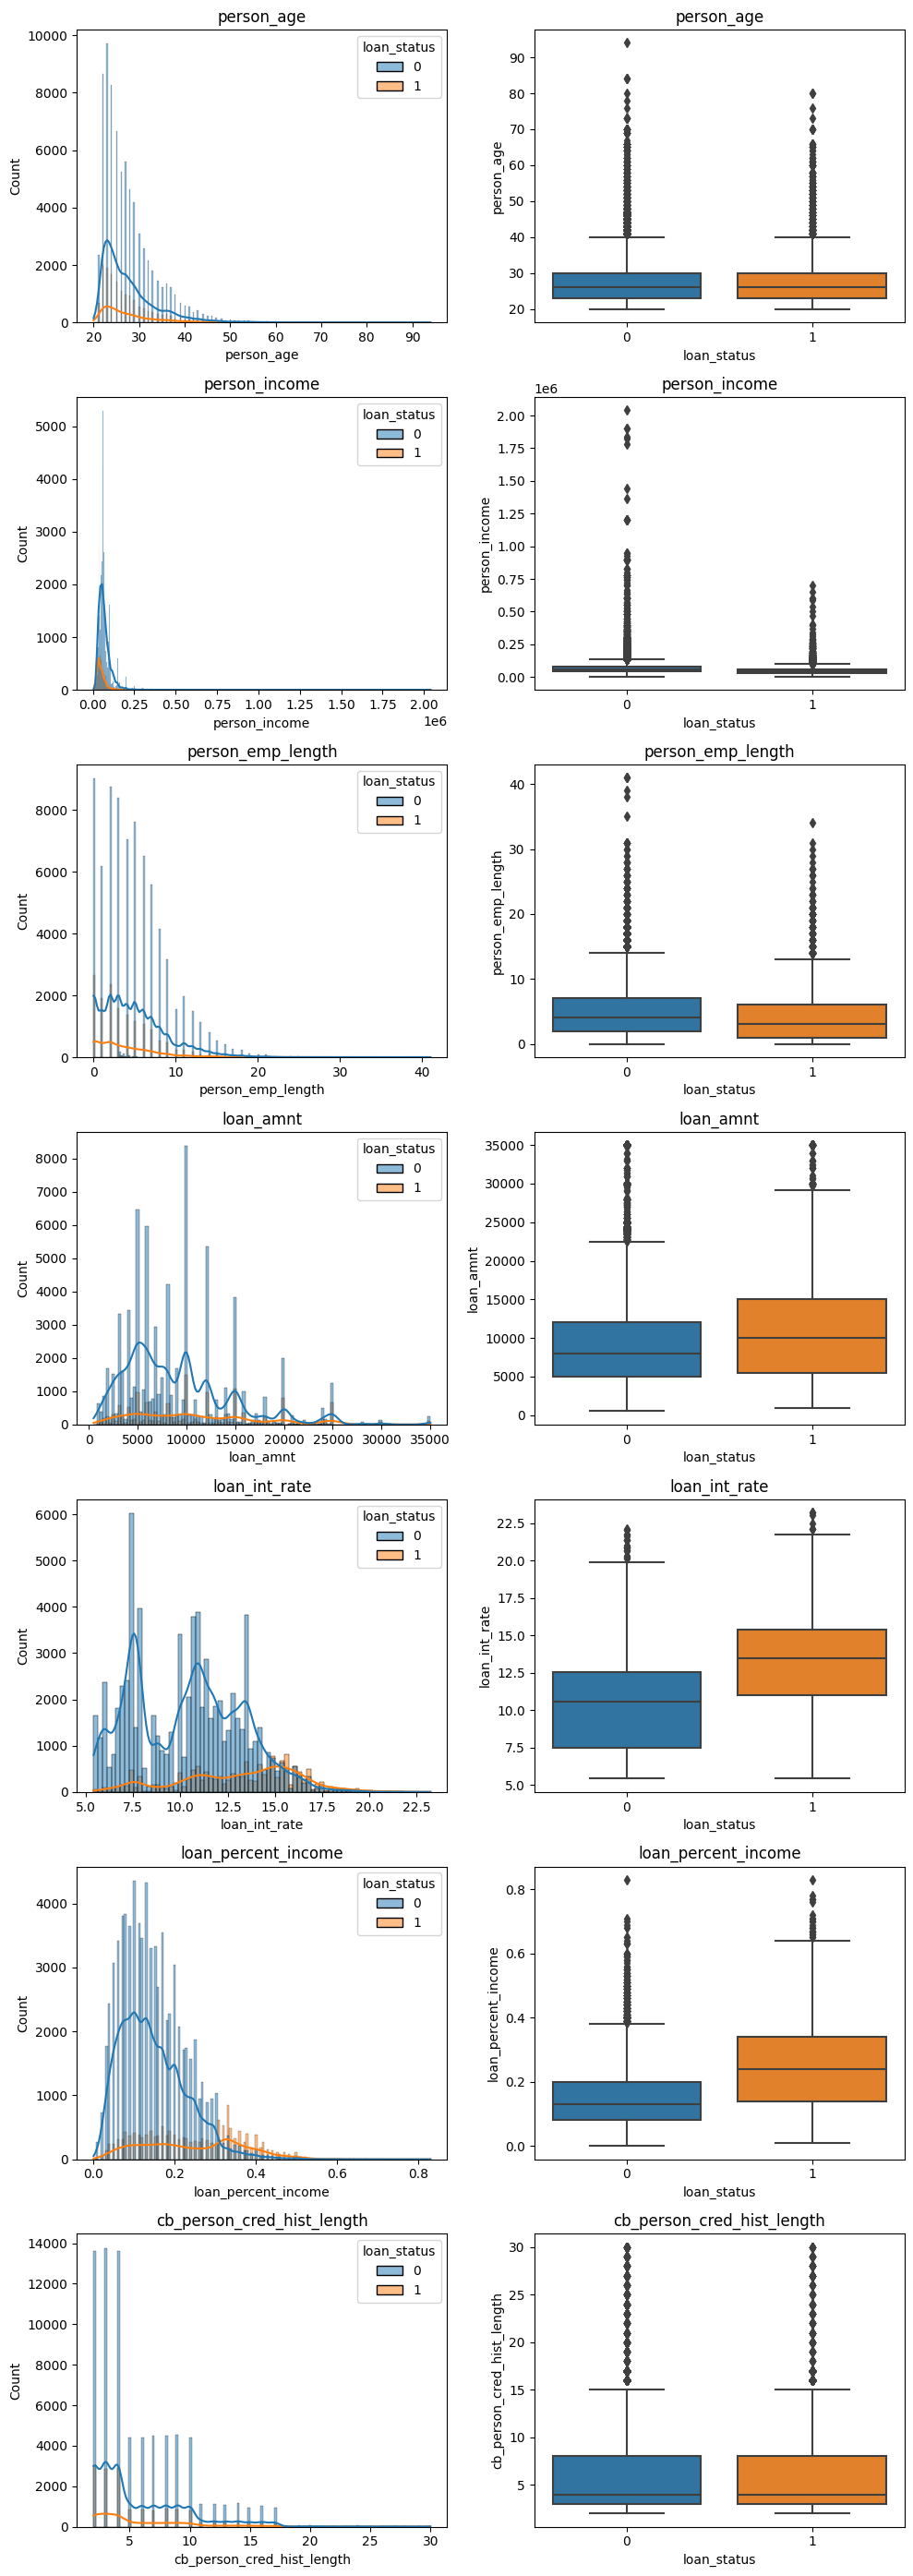

In [22]:
create_bivariate_plots_numerical(df.reset_index(drop=True), 'loan_status')

The first-row graph indicates the person's age and the number of lenders who successfully got the loan and those who failed to get the loan. The histogram shows that most lenders who successfully got the loan and most lenders who failed to get the loan are in the same group of individuals who are aged 20 to 40. From the boxplot, we can visualize that the older you get which means older than age 80 the more possibility of the lender getting the loan. However, if the lender age is between 20 to 40 the percentage of them getting a loan is 50%. The outliers which are 140 years old are get rid of. 
The second row of the graph shows the person's yearly income against the number of lenders who successfully got the loan. From the histogram, we can visualize that the majority of the lender's yearly income is less than $250,000. We also can see that the number of lenders who successfully got the loan is far more than the ones who failed to get the loan. We can see from the boxplot that some lenders were successful in obtaining a loan with incomes exceeding $2,000,000. The outlier's $6,000,000 yearly income has been removed after preprocessing. 
The third row of the histogram shows the person's employment length against the number of lenders who successfully got the loan. It clearly shows that the shorter the employment length the more possibility the lender will the loan. From the boxplot, we can visualize that the shorter the length of employment length the higher the possibility that the lenders can get the loan the majority of the lenders who successfully have the loan and the majority of the lenders who failed to get the loan are the same group of lenders which is employment length less than 20. The outliers of a lender who has worked for over 120 years have been removed after data preprocessing. 
The following variables have not much changes after the data preprocessing. Hence, we can visualize that the only changes made after data preprocessing are the person_age, person_income, and person_emp_length variables outliers removed from the datasets. From the perspective of the boxplot and histogram, other variables are unchanged. 
# **This is after preprocessing datasets.**

The first-row graph indicates the person's age and the number of lenders who successfully got the loan and those who failed to get the loan. The histogram shows that most lenders who successfully got the loan and most lenders who failed to get the loan are in the same group of individuals who are aged 20 to 40. From the boxplot, we can visualize that the older you get which means older than age 80 the more possibility of the lender getting the loan. However, if the lender age is between 20 to 40 the percentage of them getting a loan is 50%. The outliers which are 140 years old are get rid of. 

The second row of the graph shows the person's yearly income against the number of lenders who successfully got the loan. From the histogram, we can visualize that the majority of the lender's yearly income is less than $250,000. We also can see that the number of lenders who successfully got the loan is far more than the ones who failed to get the loan. We can see from the boxplot that some lenders were successful in obtaining a loan with incomes exceeding $2,000,000. The outlier's $6,000,000 yearly income has been removed after preprocessing. 

The third row of the histogram shows the person's employment length against the number of lenders who successfully got the loan. It clearly shows that the shorter the employment length the more possibility the lender will the loan. From the boxplot, we can visualize that the shorter the length of employment length the higher the possibility that the lenders can get the loan the majority of the lenders who successfully have the loan and the majority of the lenders who failed to get the loan are the same group of person which is employment length less than 20. The outliers of a lender who has worked for over 120 years have been removed after data preprocessing. 

The fourth row of the histogram shows the total loan amount the lender loans against the number of the lender getting the loan. The histogram shows that the lesser amount the lender loans the possibility of the lender getting the loan is higher. From the boxplot, we can visualize that there are many outliers that loan above 20,000 and successfully get their loan.  

The fifth row of the histogram shows the loan interest against the amount of the lenders that successfully get their loans. From the histogram, we can visualize that an interest rate of 7.5% is the highest amount in the datasets. As the loan interest rate increases the possibility of the lender successfully getting the loan decreases. We can visualize from the boxplot that the more the interest rate the lender has the more possibility that the lender will fail to get the loan higher. 

The sixth row of the histogram shows the loan percent to income against the number of lender who successfully got their loan. We can visualize from the histogram that the highest amount of lenders who successfully got the loan percentage to their income is 0.1, and this group of lenders has the highest possibility of getting the loan they wish to have. On the other hand, the boxplot shows that if the lender's loan is 10% more than their income, the possibility of them failing to get the loan increases. 

The last row of the histogram shows the credit bureau of the lender against the number of lenders who successfully got their loans. We can visualize that the lesser the credit history length of the lender, the higher the possibility that the lender successfully gets the loan is higher. If the lender's credit history length is shorter than 5 the possibility of the lender getting the loan is higher. However, from the boxplot, it seems no difference no matter how long or how short your credit bureau, the chance of getting the loan is 50%.

The following variables have not much changes after the data preprocessing. Hence, we can visualize that the only changes made after data preprocessing are the person_age, person_income, and person_emp_length variables outliers removed from the datasets. From the perspective of the boxplot and histogram, other variables are unchanged. 

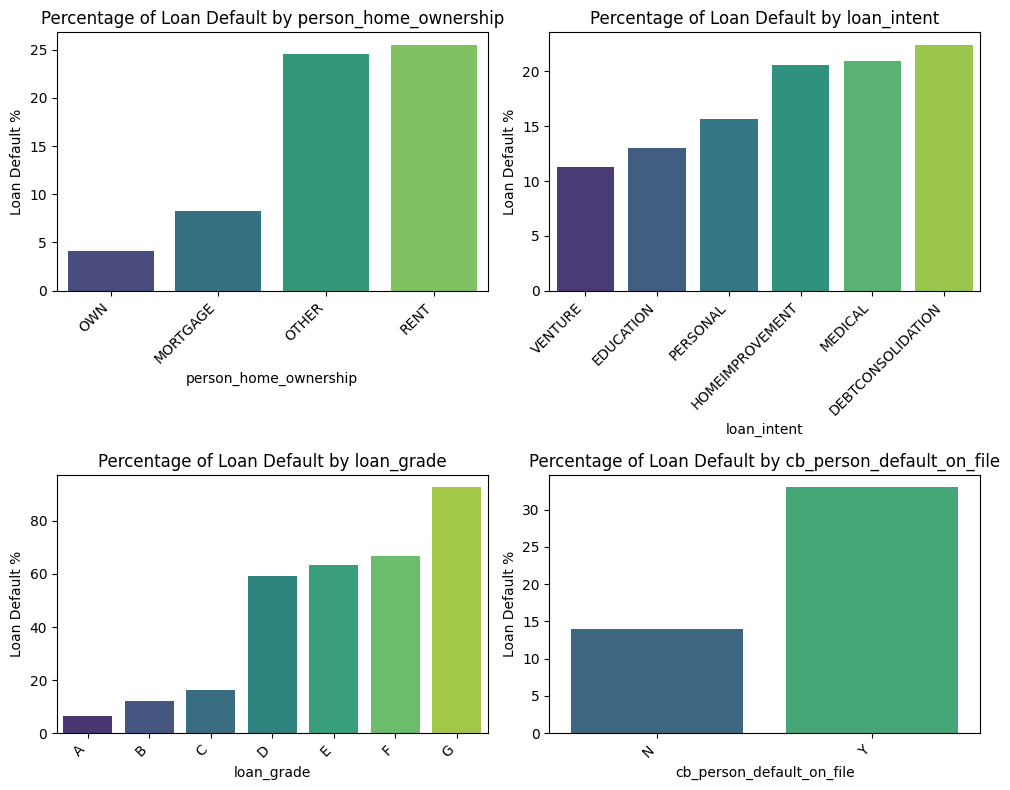

In [23]:
create_bivariate_plots_categorical(df.reset_index(drop=True), 'loan_status')

# **This is after preprocessing datasets.**

The top left corner shows the graph showing the percentage of lenders who failed to have their loan against the lender's personal home ownership. We can visualize from the histogram that if the lender owns a home, the percentage of the lenders who failed to get the loan is less than 5%. However, if the lender does not own any home properties, and they are renting a house the percentage of the lender failing to have the loan is around 25%. 

The top right corner shows the lender loan intention against the percentage of lenders who failed to have their loan. If the lender would like to borrow a loan for venture activities, the percentage of failure to have the loan is very small which is less than 15%. If the lender borrows a loan for debt consolidation the percentage of the lender failing to get the loan is above 20%. 

The bottom left shows the type of lender graded by the bank against the percentage of lenders who failed to have their loan. It follows alphabetic order that grade A lenders have a lower chance of getting rejected by banks. It shows that the grade A who fails to get the loan is less than 10%. Grade G lenders have the highest chance of failing to get the loan which is more than 80%.

The right bottom corner shows the credit bureau of the lender against the percentage of lenders who failed to have their loan. If the lender has a good credit bureau background the percentage of them who fail to have the loan is less than 15%. If the lender has a bad credit bureau background, the percentage of them failing to get the loan is more than 30%.

Overall, there is not much difference from the before data preprocessing datasets. This is because we just remove the outliers from the datasets.

In [24]:
def add_features(df):
    df2=df.copy()
    
    df2['income_bin'] = pd.qcut(df2['person_income'], 5, labels=False)
    df2['rate_bin'] = pd.qcut(df2['loan_int_rate'], 5, labels=False)
    df2["person_emp_length"] = df2["person_emp_length"].astype("int")
    df2['loan_grade'] = df2['loan_grade'].replace({'F': 'E', 'G': 'E'})
    
    df2['loan_to_income'] =  np.round(df2['loan_amnt']/df2['person_income'], 2)
    df2['total_amount_payable'] = np.floor(df2['loan_amnt'] * (1+df2['loan_int_rate']/100))
    df2['interest'] = np.floor(df2['loan_amnt'] * df2['loan_int_rate']/100)
    df2["amt_payable_to_income"] = np.round(df2['total_amount_payable']/df2['person_income'], 2)
    
    df2["loan_percent_error"] = np.round(df2['loan_to_income'] - df2["loan_percent_income"], 2)
    df2["income_2"] = np.floor(df2['loan_amnt']/df2["loan_percent_income"])
    df2["amt_payable_to_income_2"] = np.round(df2['total_amount_payable']/df2['income_2'], 2)
    
    df2['credit_hist_vs_age'] = np.round(df2['cb_person_cred_hist_length'] / df2['person_age'], 2)
    df2['credit_hist_vs_work'] = np.round(df2['person_emp_length']/df2['cb_person_cred_hist_length'], 2)
    df2['income_vs_age'] = np.round(df2['person_income'] / df2['person_age'], 2)
    df2['work_vs_age'] = np.round(df2['person_emp_length']/df2['person_age'], 2)

    df2['risk_flag'] = np.where((df2['cb_person_default_on_file'] == 'Y') & (df2['loan_grade'].isin(['D', 'E'])), 1, 0)
    df2['ratio1'] = np.round((df2['total_amount_payable']/df2['person_income'])*(df2['person_emp_length']/df2['person_age']), 2)
    df2['ratio2'] = np.floor(df2['person_emp_length']/df2['person_age']*df2['person_income'])

    df2["grade_home_interaction"] = df2['person_home_ownership'].astype(str) + '_' + df2['loan_grade'].astype(str)
    df2["grade_intent_interaction"] = df2['loan_intent'].astype(str) + '_' + df2['loan_grade'].astype(str)
    df2["home_intent_interaction"] = df2['person_home_ownership'].astype(str) + '_' + df2['loan_intent'].astype(str)

    return df2

In [25]:
df_processed = add_features(df)
df_test_processed = add_features(test)

In [26]:
df_processed_2= add_features(df)
df_test_processed_2 = add_features(test)

In [27]:
df_processed_2

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,...,credit_hist_vs_age,credit_hist_vs_work,income_vs_age,work_vs_age,risk_flag,ratio1,ratio2,grade_home_interaction,grade_intent_interaction,home_intent_interaction
0,37,35000,RENT,0,EDUCATION,B,6000,11.49,0.17,N,...,0.38,0.00,945.95,0.00,0,0.00,0.0,RENT_B,EDUCATION_B,RENT_EDUCATION
1,22,56000,OWN,6,MEDICAL,C,4000,13.35,0.07,N,...,0.09,3.00,2545.45,0.27,0,0.02,15272.0,OWN_C,MEDICAL_C,OWN_MEDICAL
2,29,28800,OWN,8,PERSONAL,A,6000,8.90,0.21,N,...,0.34,0.80,993.10,0.28,0,0.06,7944.0,OWN_A,PERSONAL_A,OWN_PERSONAL
3,30,70000,RENT,14,VENTURE,B,12000,11.11,0.17,N,...,0.17,2.80,2333.33,0.47,0,0.09,32666.0,RENT_B,VENTURE_B,RENT_VENTURE
4,22,60000,RENT,2,MEDICAL,A,6000,6.92,0.10,N,...,0.14,0.67,2727.27,0.09,0,0.01,5454.0,RENT_A,MEDICAL_A,RENT_MEDICAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1,PERSONAL,C,5800,13.16,0.11,N,...,0.53,0.03,929.82,0.02,0,0.00,929.0,MORTGAGE_C,PERSONAL_C,MORTGAGE_PERSONAL
32577,54,120000,MORTGAGE,4,PERSONAL,A,17625,7.49,0.15,N,...,0.35,0.21,2222.22,0.07,0,0.01,8888.0,MORTGAGE_A,PERSONAL_A,MORTGAGE_PERSONAL
32578,65,76000,RENT,3,HOMEIMPROVEMENT,B,35000,10.99,0.46,N,...,0.43,0.11,1169.23,0.05,0,0.02,3507.0,RENT_B,HOMEIMPROVEMENT_B,RENT_HOMEIMPROVEMENT
32579,56,150000,MORTGAGE,5,PERSONAL,B,15000,11.48,0.10,N,...,0.46,0.19,2678.57,0.09,0,0.01,13392.0,MORTGAGE_B,PERSONAL_B,MORTGAGE_PERSONAL


In [28]:
df_processed

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,...,credit_hist_vs_age,credit_hist_vs_work,income_vs_age,work_vs_age,risk_flag,ratio1,ratio2,grade_home_interaction,grade_intent_interaction,home_intent_interaction
0,37,35000,RENT,0,EDUCATION,B,6000,11.49,0.17,N,...,0.38,0.00,945.95,0.00,0,0.00,0.0,RENT_B,EDUCATION_B,RENT_EDUCATION
1,22,56000,OWN,6,MEDICAL,C,4000,13.35,0.07,N,...,0.09,3.00,2545.45,0.27,0,0.02,15272.0,OWN_C,MEDICAL_C,OWN_MEDICAL
2,29,28800,OWN,8,PERSONAL,A,6000,8.90,0.21,N,...,0.34,0.80,993.10,0.28,0,0.06,7944.0,OWN_A,PERSONAL_A,OWN_PERSONAL
3,30,70000,RENT,14,VENTURE,B,12000,11.11,0.17,N,...,0.17,2.80,2333.33,0.47,0,0.09,32666.0,RENT_B,VENTURE_B,RENT_VENTURE
4,22,60000,RENT,2,MEDICAL,A,6000,6.92,0.10,N,...,0.14,0.67,2727.27,0.09,0,0.01,5454.0,RENT_A,MEDICAL_A,RENT_MEDICAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1,PERSONAL,C,5800,13.16,0.11,N,...,0.53,0.03,929.82,0.02,0,0.00,929.0,MORTGAGE_C,PERSONAL_C,MORTGAGE_PERSONAL
32577,54,120000,MORTGAGE,4,PERSONAL,A,17625,7.49,0.15,N,...,0.35,0.21,2222.22,0.07,0,0.01,8888.0,MORTGAGE_A,PERSONAL_A,MORTGAGE_PERSONAL
32578,65,76000,RENT,3,HOMEIMPROVEMENT,B,35000,10.99,0.46,N,...,0.43,0.11,1169.23,0.05,0,0.02,3507.0,RENT_B,HOMEIMPROVEMENT_B,RENT_HOMEIMPROVEMENT
32579,56,150000,MORTGAGE,5,PERSONAL,B,15000,11.48,0.10,N,...,0.46,0.19,2678.57,0.09,0,0.01,13392.0,MORTGAGE_B,PERSONAL_B,MORTGAGE_PERSONAL


In [29]:
X_train_blend = df_processed.drop(columns=["loan_status"])
y_train_blend = df_processed.loan_status

In [30]:
X_train_lgbm = df_processed.drop(columns=["loan_status"])
y_train_lgbm = df_processed.loan_status

In [31]:
X_forblend = df_processed.drop(columns=["loan_status"])
y_forblend= df_processed["loan_status"]
X_train_forblend, X_test_forblend, y_train_forblend, y_test_forblend = train_test_split(X_forblend, y_forblend, test_size=0.2, random_state=42, stratify=y_forblend)

In [32]:
# Encoding categorical features for CatBoost
X_train_forblend = X_train_forblend.astype("string").astype("category")
X_test_forblend = X_test_forblend.astype("string").astype("category")
cat_cols_forblend = X_train_forblend.columns[X_train_forblend.dtypes == "category"].tolist()

In [33]:
df_processed = df_processed.select_dtypes(include=[np.number])

# Replace infinite values with NaN
df_processed.replace([np.inf, -np.inf], np.nan, inplace=True)
# Apply get_dummies() first, then standardize the data
df_processed = df_processed.dropna()

df_processed = pd.get_dummies(df_processed, drop_first=True)

# Ensure no missing values
df_processed.fillna(df_processed.mean(), inplace=True)

# Standardize the data
y  =df_processed['loan_status']
df_processed = df_processed.drop(columns=['loan_status'])

standardized_data = scaler.fit_transform(df_processed)

# Convert standardized data back to DataFrame with the correct column names
data_standardized_df = pd.DataFrame(standardized_data, columns=df_processed.columns)

# Calculate KMO
kmo_all, kmo_model = calculate_kmo(data_standardized_df)
print(f"Updated KMO Model Score: {kmo_model}")

Updated KMO Model Score: 0.7221192647586728


Kaiser-Meyer-Olkin (KMO) is to measure how well the variables in the datasets relate to each other through the underlying factor. Hence, the higher value of KMO indicates the factor analysis is more towards the sampling adequacy. High KMO values suggest that correlations are large relative to partial correlations, indicating that the variables share a common factor structure. After the preprocessing data have been done the KMO test has been increased to 0.722. This means that the correlation among the variables is stronger than before, and the partial correlations are lower. 

# **For Classification**

In [34]:
encoder = LabelEncoder()

df_processed_2['person_home_ownership'] = encoder.fit_transform(df_processed_2['person_home_ownership'])
df_processed_2['loan_intent'] = encoder.fit_transform(df_processed_2['loan_intent'])
df_processed_2['loan_grade'] = encoder.fit_transform(df_processed_2['loan_grade'])
df_processed_2['cb_person_default_on_file'] = encoder.fit_transform(df['cb_person_default_on_file'])

df_processed_2['grade_home_interaction'] = encoder.fit_transform(df_processed_2['grade_home_interaction'])
df_processed_2['grade_intent_interaction'] = encoder.fit_transform(df_processed_2['grade_intent_interaction'])
df_processed_2['home_intent_interaction'] = encoder.fit_transform(df_processed_2['home_intent_interaction'])

In [35]:
X = df_processed_2.drop(['loan_status'], axis= 1)
y = df_processed_2['loan_status']

In [36]:
df_processed_2 = df_processed_2.select_dtypes(include=[np.number])

# Replace infinite values with NaN
df_processed_2.replace([np.inf, -np.inf], np.nan, inplace=True)
# Apply get_dummies() first, then standardize the data
df_processed_2 = df_processed_2.dropna()
df_processed_2 = pd.get_dummies(df_processed_2, drop_first=True)

# Ensure no missing values
df_processed_2.fillna(df_processed_2.mean(), inplace=True)

In [37]:
# Standardize the data
standardized_data_2 = scaler.fit_transform(df_processed_2)

# Convert standardized data back to DataFrame with the correct column names
data_standardized_df_2 = pd.DataFrame(standardized_data_2, columns=df_processed_2.columns)

# Calculate KMO
kmo_all, kmo_model = calculate_kmo(data_standardized_df_2)
print(f"Updated KMO Model Score: {kmo_model}")

Updated KMO Model Score: 0.7294469909392461


After the preprocessing, the values with NaN are replaced by infinite values and missing values also have been filled. The higher value in KMO score, that means the variable will more well-suited for factor analysis. Inversely, if the lower value in KMO score, then the variable may not share much variance. Our overall KMO score after preprocessing get about 0.7297, this means that the dataset is quite suitable and adequate for the factor analysis.

<Axes: >

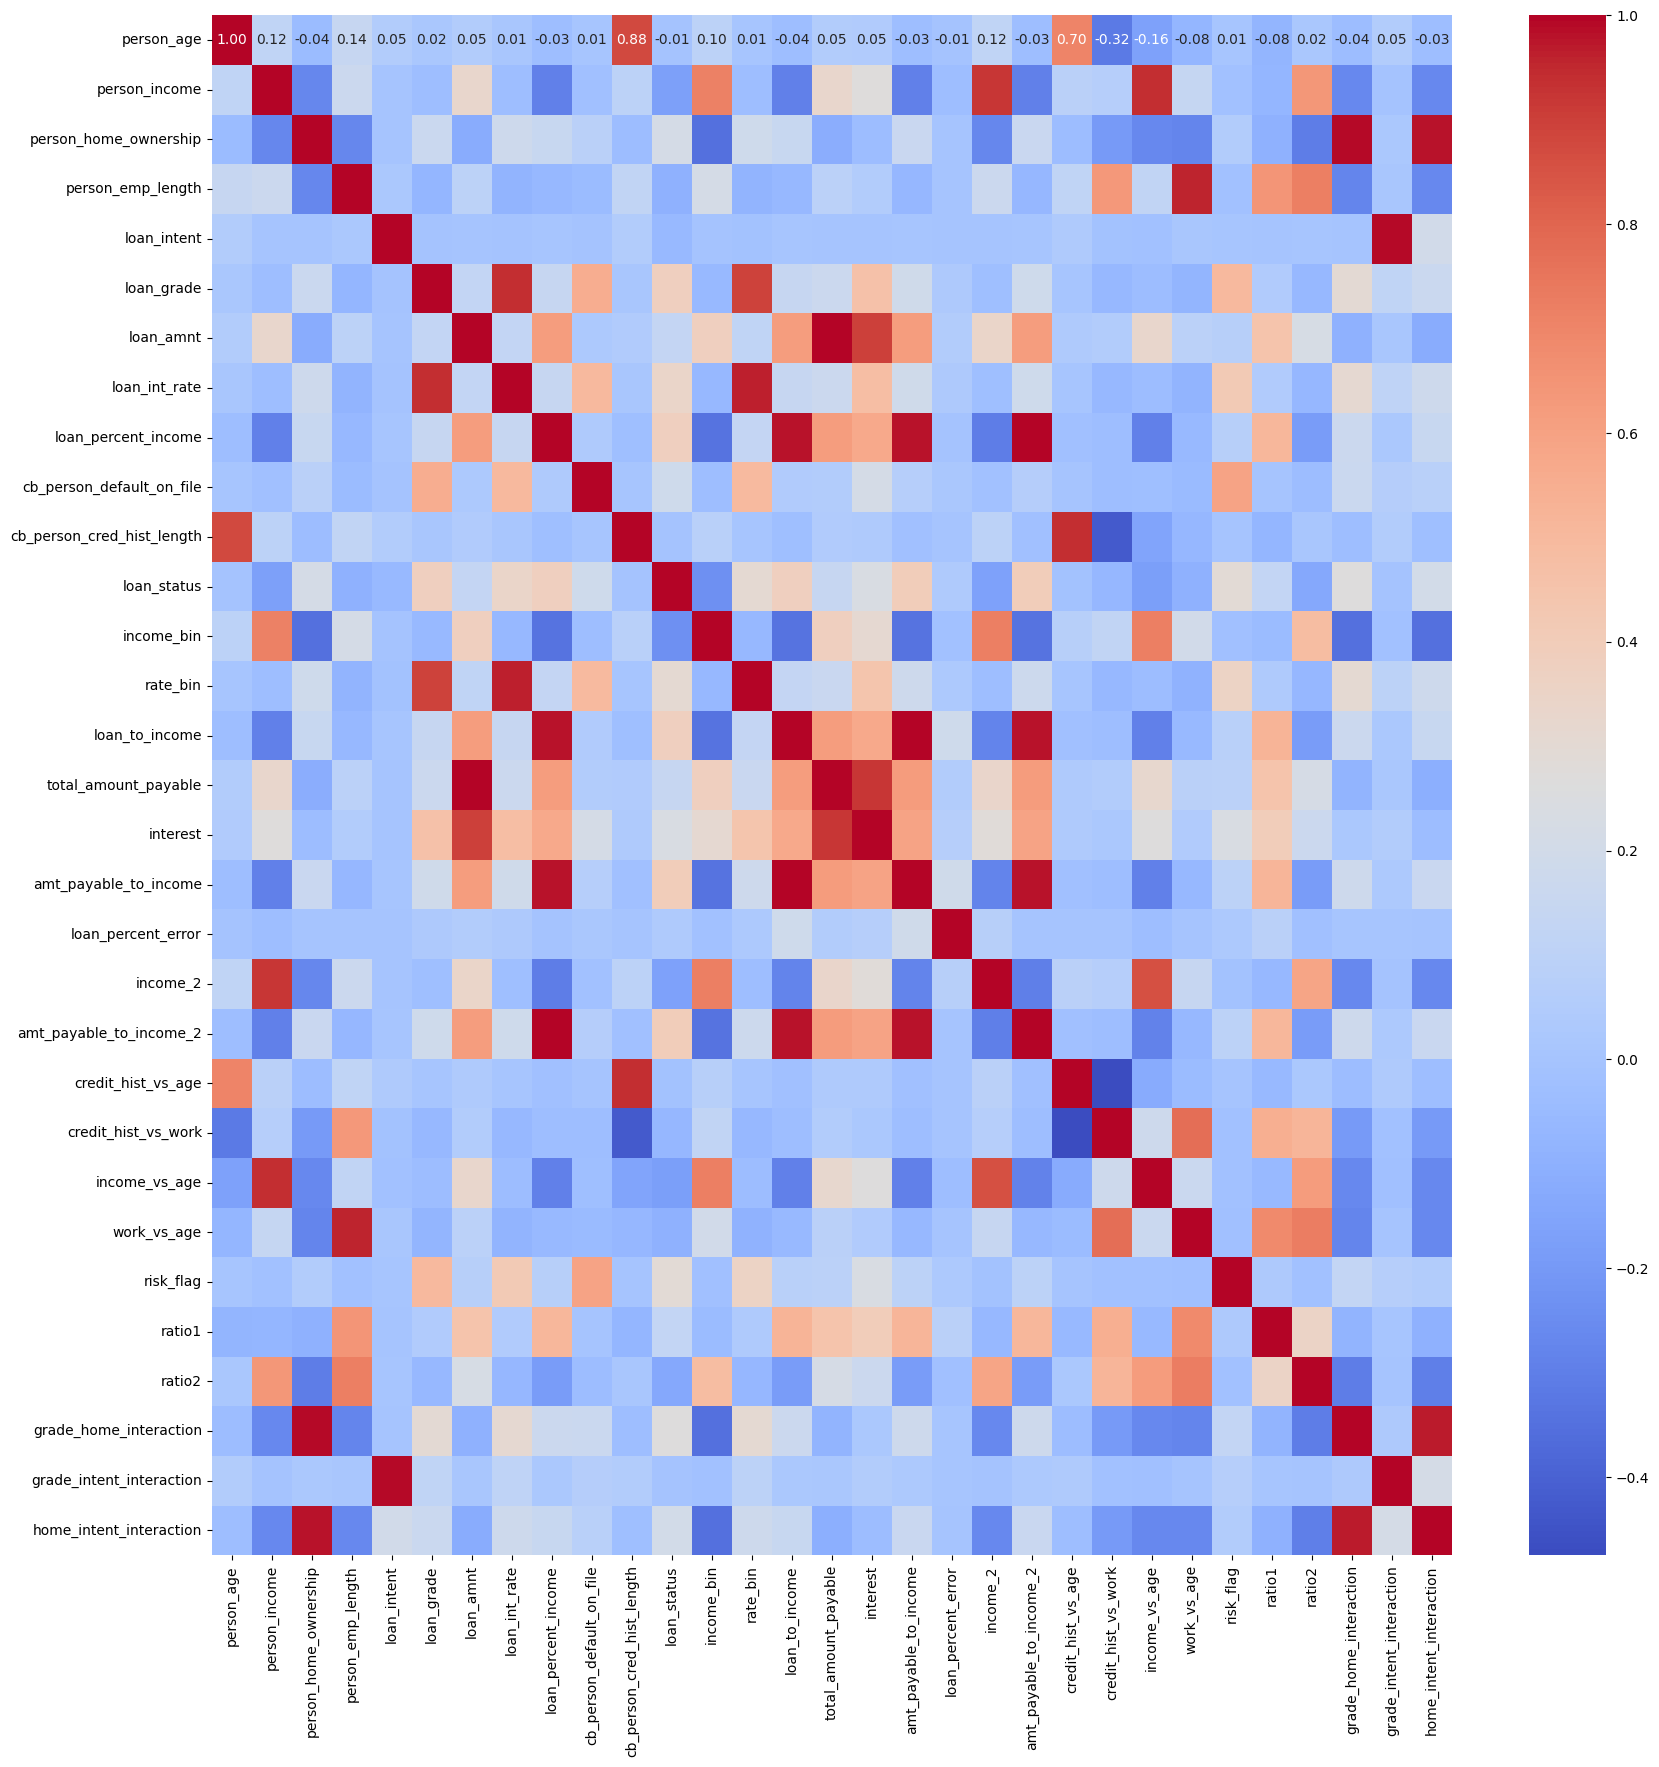

In [38]:
plt.figure(figsize=(20,20))
corr = data_standardized_df_2.corr()
sns.heatmap(data_standardized_df_2.corr(), annot= True, fmt= "0.2f", cmap= 'coolwarm')

This is a heatmap of every dataset's properties, including the feature engineering that was carried out. As we can see from the heatmap, certain features have a strong positive association with the other variables. For example, the amt_payable_to_income_2 has a 1.00 strong positive correlation with loan_percent_income. With a negative correlation of -0.47 with the cb_person_default_on_file attribute, the credit_hist_vs_work variable has the highest correlation. 

In [39]:
X

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,...,credit_hist_vs_age,credit_hist_vs_work,income_vs_age,work_vs_age,risk_flag,ratio1,ratio2,grade_home_interaction,grade_intent_interaction,home_intent_interaction
0,37,35000,3,0,1,1,6000,11.49,0.17,0,...,0.38,0.00,945.95,0.00,0,0.00,0.0,16,6,19
1,22,56000,2,6,3,2,4000,13.35,0.07,0,...,0.09,3.00,2545.45,0.27,0,0.02,15272.0,12,17,15
2,29,28800,2,8,4,0,6000,8.90,0.21,0,...,0.34,0.80,993.10,0.28,0,0.06,7944.0,10,20,16
3,30,70000,3,14,5,1,12000,11.11,0.17,0,...,0.17,2.80,2333.33,0.47,0,0.09,32666.0,16,26,23
4,22,60000,3,2,3,0,6000,6.92,0.10,0,...,0.14,0.67,2727.27,0.09,0,0.01,5454.0,15,15,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,0,1,4,2,5800,13.16,0.11,0,...,0.53,0.03,929.82,0.02,0,0.00,929.0,2,22,4
32577,54,120000,0,4,4,0,17625,7.49,0.15,0,...,0.35,0.21,2222.22,0.07,0,0.01,8888.0,0,20,4
32578,65,76000,3,3,2,1,35000,10.99,0.46,0,...,0.43,0.11,1169.23,0.05,0,0.02,3507.0,16,11,20
32579,56,150000,0,5,4,1,15000,11.48,0.10,0,...,0.46,0.19,2678.57,0.09,0,0.01,13392.0,1,21,4


In [40]:
X.replace([np.inf, -np.inf], np.nan, inplace=True)
# Apply get_dummies() first, then standardize the data
X.fillna(X.mean(), inplace=True)

In [41]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

Text(0.5, 1.0, 'Before LDA')

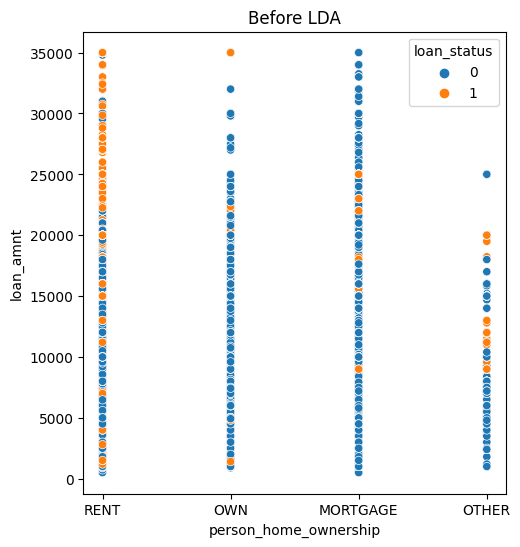

In [42]:
plt.figure(figsize= (12, 6))
plt.subplot(1,2,1)
sns.scatterplot(x= 'person_home_ownership', y= 'loan_amnt', hue= 'loan_status', data= df)

plt.title('Before LDA')

This is a scatter plot that indicates loan_amnt and person_hom_ownership before applying LDA. The person_hom_ownership is categorized into four categories rent, own, mortgage, and other. The data points are categorized by loan_status, in which class 0 (blue) represents approved (non-default) and class 1 (orange) represents rejected (default).

The two classes are not clearly distinguished from one another in each variable; they are in one verticles line, but the plot is dispersed over the line. This suggests that the classes in the original feature space are not linearly separable. Before applying LDA, we can see that there are many overlaps of the data points, because of this, there will be a challenge when classifying the data.

In [43]:
lda = LinearDiscriminantAnalysis()
lda_t = lda.fit_transform(X_resampled,y_resampled)

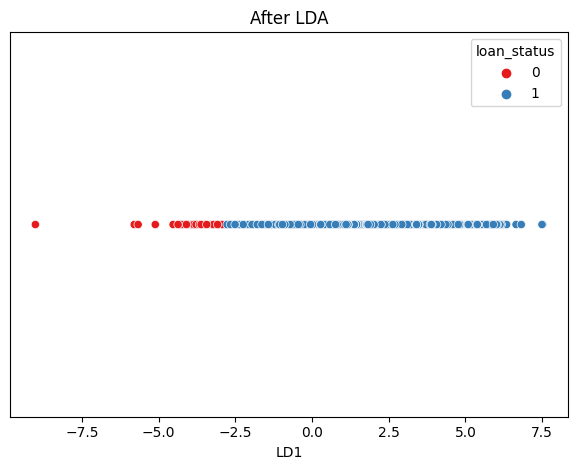

In [44]:
# Transform data with LDA
X_lda = lda.transform(X_resampled)
lda_df = pd.DataFrame(data=X_lda, columns=['LD1'])

# Rename column to remove extra space in 'loan_status'
lda_df['loan_status'] = y_resampled.values

# Plotting the LDA-transformed data (1D scatter plot using only LD1)
sns.scatterplot(x='LD1', y=[0]*len(lda_df), hue='loan_status', data=lda_df, palette='Set1', marker='o')
plt.title('After LDA')

# Adjust layout for clear display

plt.tight_layout()
plt.yticks([])  # Remove y-axis ticks as there's no second dimension
plt.show()


This is the scatter plot after applying LDA. LD1 is the single linear discriminant extracted by LDA and represents the x-axis. The data points same as before applying LDA, categorized by loan_status but with different colors which class 0 (red) represents approved status and class 1 (blue) represents rejected status.

LDA successfully reduced the dimensionality of the data and maximized the separation between the two classes. The two classes are well-separated and distributed linearly along LD1. After applying LDA, the overlap between classes in the original feature space is minimized, this will become easier to classify. Also, we know the boundary of this scatter plot graph which is about -10 and about 7.5.

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled,y_resampled, test_size= 0.3, random_state= 42)
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [46]:
y_pred = lda.predict(X_test)
print("Acuracy: ",accuracy_score(y_test, y_pred))

precision = precision_score(y_test, y_pred, average= 'weighted')
recall = recall_score(y_test, y_pred, average= 'weighted')
print("precision_score: ", precision)
print("recall_score: ", recall)

Acuracy:  0.880169834565294
precision_score:  0.8822956026185073
recall_score:  0.880169834565294


This is the prediction of the testing dataset after applying Linear Discriminant Analysis.
- Acuracy:  0.8781958195819582
- Precision Score:  0.880328482284577
- Recall Score:  0.8781958195819582

In [47]:
X_train_LDA = lda.fit_transform(X_train, y_train)
X_test_LDA = lda.transform(X_test)

clf1 = DecisionTreeClassifier(max_depth=2, random_state=42)
clf1.fit(X_train_LDA, y_train)

DecisionTreeClassifier(max_depth=2, random_state=42)

In [48]:
y_pred_lda_cart = clf1.predict(X_test_LDA)
accuracy = accuracy_score(y_test, y_pred_lda_cart)
accuracy

print("accuracy: ", accuracy)

precision = precision_score(y_test, y_pred_lda_cart, average= 'weighted')
recall = recall_score(y_test, y_pred_lda_cart, average= 'weighted')
print("precision_score: ", precision)
print("recall_score: ", recall)

accuracy:  0.8804558254135868
precision_score:  0.8812086573161988
recall_score:  0.8804558254135868


This is the prediction after the Decision Tree Classifier.
- Accuracy:  0.8804
- Precision Score:  0.8812
- Recall Score:  0.8805

We can find out that there are a little higher accuracy and recall score compare with before apply Decision Tree Classifier.

In [49]:
import pingouin as pg
pg.cronbach_alpha(data=X_resampled)

(0.6287030802882422, array([0.626, 0.631]))

Cronbach's Alpha is used to measure how closely related a set of variables are as a group. We got a value of 0.6287 which indicates the overall reliability score. This value is lower than 0.7, so it suggests a poor reliability of the dataset. The true value lies between 0.626 (lower bound) to 0.631 (upper bound) with low confidence. This validates the reliability estimate's consistency and stability.

In [50]:
scaler = StandardScaler()
scaler.fit(X_resampled)
X_resampled = scaler.transform(X_resampled)

In [51]:
pca = PCA(n_components=8)
pca.fit(X_resampled)
X_pca = pca.transform(X_resampled)

print("Explained Variance Ratio:", pca.explained_variance_ratio_)

Explained Variance Ratio: [0.22405931 0.18749729 0.12552218 0.10231723 0.08140508 0.07033872
 0.06049841 0.03737702]


We reduce the dataset to 8 principal components.

First principal component (PC1)
- Explain about 22.47% of the total variance

Second principal component (PC2)
- Explain about 18.84% of the total variance

Third principal component (PC3)
- Explain about 12.56% of the total variance

Fourth principal component (PC4)
- Explain about 10.26% of the total variance

Fifth principal component (PC5)
- Explain about 8.17% of the total variance

Sixth principal component (PC6)
- Explain about 7.03% of the total variance

Seventh principal component (PC7)
- Explain about 6.05% of the total variance

Eighth principal component (PC8)
- Explain about 3.74% of the total variance

The total of these component is about 89.12% of the total variance, the remaining value about 10.88% is contributed by the other components, which can choose to ignore.

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_pca,y_resampled, test_size= 0.3, random_state= 42)

In [53]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [54]:
pred = clf.predict(X_test)

In [55]:
accuracy = accuracy_score(pred, y_test)
recall = recall_score(pred, y_test, average= 'weighted')
precision = precision_score(pred, y_test, average= 'weighted')

print("Accuracy: ", accuracy)
print("Recall: ", recall)
print("Precicion: ", precision)


Accuracy:  0.825853572685674
Recall:  0.825853572685674
Precicion:  0.825948471065408


This is the prediction with using Decision Tree Classifier.

The testing dataset already applyed with PCA.
- Accuracy: 0.8286248624862487
- Recall: 0.8286248624862487
- Precicion: 0.8287017709405581

In [56]:
from factor_analyzer import FactorAnalyzer, calculate_bartlett_sphericity, calculate_kmo

In [57]:
chi_square_value, p_value = calculate_bartlett_sphericity(X_resampled)
print("Chi Square Value:", chi_square_value)
p_value

Chi Square Value: 14751123.162586221


0.0

The Bartlett's test statistic, Chi Square Value, get a very high value, which is about 14751123.162586221. This show that the strong evidence against the null hypothesis. We get a 0 p-value essentially, which means that the null hypothesis is rejected. The null hypothesis is the variables in dataset are uncorrelated, and the correlation matrix is an identity matrix. Due to the reason that p-value smaller than 0.05, so null hypothesis is rejected (variables in dataset are correlation).

In [58]:
n_factors = X_resampled.shape[1]
fa = FactorAnalyzer(n_factors, rotation=None)
fa.fit(corr)

FactorAnalyzer(n_factors=30, rotation=None, rotation_kwargs={})

In [59]:
ev, v = fa.get_eigenvalues()
idx = np.where(ev > 1)[0]

n_factors_kg = idx.size

print(f"Number of Factors (Kaiser-Guttman Rule): {n_factors_kg}")

Number of Factors (Kaiser-Guttman Rule): 7


In [60]:
len(ev)

31

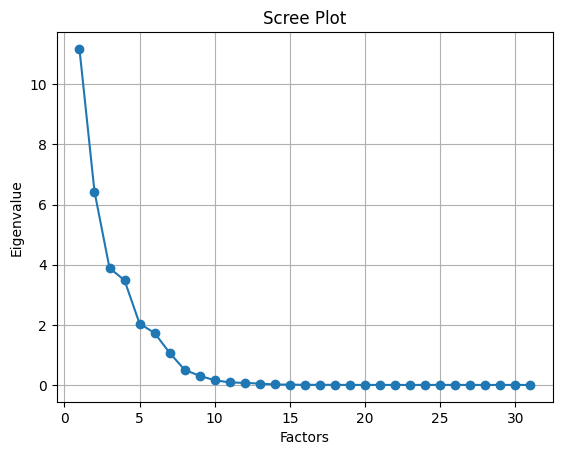

In [61]:
plt.plot(range(1,n_factors+2 ), ev, marker= "o")
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot')
plt.grid()
plt.show()

The Kaiser-Guttman Rule is used for check that is the eigencalue of the factor greater than 1.

The result get 7 factors, which means that retains 7 factors have eigenvalue greater than 1.

In [62]:
from sklearn.decomposition import FactorAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

fa = FactorAnalysis(n_components=4)
X_train_factors = fa.fit_transform(X_train)
X_test_factors = fa.transform(X_test)

# Classification
clf = RandomForestClassifier()
clf.fit(X_train_factors, y_train)
y_pred = clf.predict(X_test_factors)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
recall_fa = recall_score(y_pred, y_test, average= 'weighted')
precision_fa = precision_score(y_pred, y_test, average= 'weighted')
print(f"recall score: {recall_fa}")
print(f"precision: {precision_fa}")


Accuracy: 0.8594244984160507
recall score: 0.8594244984160507
precision: 0.8594682756996519


The dataset have applyed the Factor Analyzer with None rotation

This is the prediction with using Decision Tree Classifier.

- Accuracy: 0.8567844172994388
- Recall: 0.8567844172994388
- Precicion: 0.8568119579820282

In [63]:
n_factors = X_resampled.shape[1]
fa = FactorAnalyzer(n_factors, rotation='oblimin')
fa.fit(corr)

FactorAnalyzer(n_factors=30, rotation='oblimin', rotation_kwargs={})

In [64]:
ev, v = fa.get_eigenvalues()
idx = np.where(ev > 1)[0]

n_factors_kg = idx.size

print(f"Number of Factors (Kaiser-Guttman Rule): {n_factors_kg}")

Number of Factors (Kaiser-Guttman Rule): 7


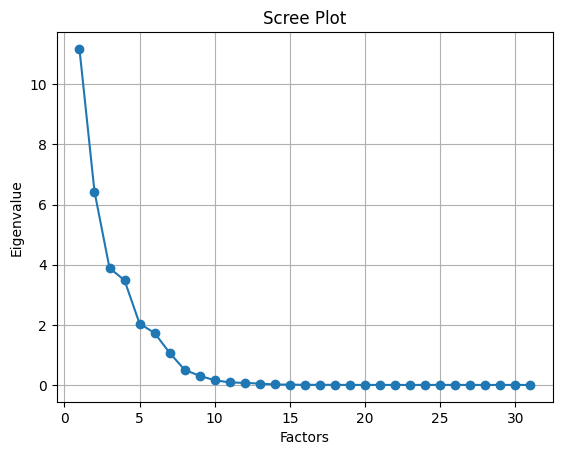

In [65]:
plt.plot(range(1,n_factors + 2), ev, marker= "o")
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot')
plt.grid()
plt.show()

This scree plot show the graph of the factors and their eigenvalue.

From the graph, there are 7 factors that are having the eigenvalue that greater than 1. The highest eigenvalue is greater than 11, and the lowest is about 0.

In [66]:
from sklearn.decomposition import FactorAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

fa = FactorAnalysis(n_components=4)
X_train_factors = fa.fit_transform(X_train)
X_test_factors = fa.transform(X_test)

# Classification
clf = RandomForestClassifier()
clf.fit(X_train_factors, y_train)
y_pred = clf.predict(X_test_factors)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
recall_fa = recall_score(y_pred, y_test, average= 'weighted')
precision_fa = precision_score(y_pred, y_test, average= 'weighted')
print(f"recall score: {recall_fa}")
print(f"precision: {precision_fa}")


Accuracy: 0.8585445265751496
recall score: 0.8585445265751496
precision: 0.8586063067202186


In [67]:
n_factors = X_resampled.shape[1]
fa = FactorAnalyzer(n_factors, rotation='varimax')
fa.fit(corr)

FactorAnalyzer(n_factors=30, rotation='varimax', rotation_kwargs={})

In [68]:
ev, v = fa.get_eigenvalues()
idx = np.where(ev > 1)[0]

n_factors_kg = idx.size

print(f"Number of Factors (Kaiser-Guttman Rule): {n_factors_kg}")

Number of Factors (Kaiser-Guttman Rule): 7


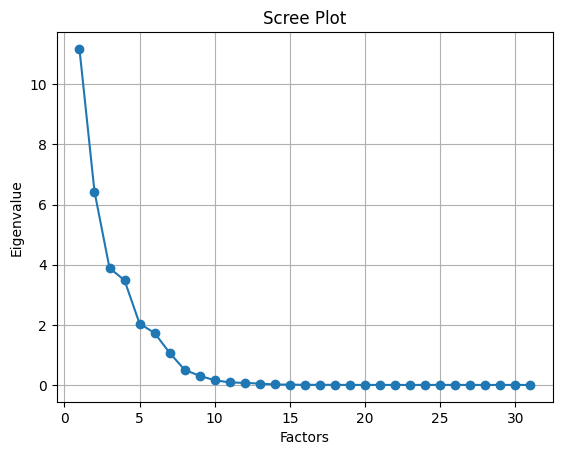

In [69]:
plt.plot(range(1,n_factors + 2), ev, marker= "o")
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot')
plt.grid()
plt.show()

This scree plot show the graph of the factors and their eigenvalue.

From the graph, there are 7 factors that are having the eigenvalue that greater than 1. The highest eigenvalue is greater than 11, and the lowest is about 0.

In [70]:
from sklearn.decomposition import FactorAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

fa = FactorAnalysis(n_components=4)
X_train_factors = fa.fit_transform(X_train)
X_test_factors = fa.transform(X_test)

# Classification
clf = RandomForestClassifier()
clf.fit(X_train_factors, y_train)
y_pred = clf.predict(X_test_factors)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
recall_fa = recall_score(y_pred, y_test, average= 'weighted')
precision_fa = precision_score(y_pred, y_test, average= 'weighted')
print(f"recall score: {recall_fa}")
print(f"precision: {precision_fa}")


Accuracy: 0.8590725096796903
recall score: 0.8590725096796903
precision: 0.8591084236152162


The dataset have applyed the Factor Analyzer with varimax rotation

This is the prediction with using Decision Tree Classifier.

- Accuracy: 0.8590
- Recall: 0.8590
- Precicion: 0.8591

In [71]:
preds_train, preds_test = pd.DataFrame(), pd.DataFrame()

In [72]:
X_train_blend

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,...,credit_hist_vs_age,credit_hist_vs_work,income_vs_age,work_vs_age,risk_flag,ratio1,ratio2,grade_home_interaction,grade_intent_interaction,home_intent_interaction
0,37,35000,RENT,0,EDUCATION,B,6000,11.49,0.17,N,...,0.38,0.00,945.95,0.00,0,0.00,0.0,RENT_B,EDUCATION_B,RENT_EDUCATION
1,22,56000,OWN,6,MEDICAL,C,4000,13.35,0.07,N,...,0.09,3.00,2545.45,0.27,0,0.02,15272.0,OWN_C,MEDICAL_C,OWN_MEDICAL
2,29,28800,OWN,8,PERSONAL,A,6000,8.90,0.21,N,...,0.34,0.80,993.10,0.28,0,0.06,7944.0,OWN_A,PERSONAL_A,OWN_PERSONAL
3,30,70000,RENT,14,VENTURE,B,12000,11.11,0.17,N,...,0.17,2.80,2333.33,0.47,0,0.09,32666.0,RENT_B,VENTURE_B,RENT_VENTURE
4,22,60000,RENT,2,MEDICAL,A,6000,6.92,0.10,N,...,0.14,0.67,2727.27,0.09,0,0.01,5454.0,RENT_A,MEDICAL_A,RENT_MEDICAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1,PERSONAL,C,5800,13.16,0.11,N,...,0.53,0.03,929.82,0.02,0,0.00,929.0,MORTGAGE_C,PERSONAL_C,MORTGAGE_PERSONAL
32577,54,120000,MORTGAGE,4,PERSONAL,A,17625,7.49,0.15,N,...,0.35,0.21,2222.22,0.07,0,0.01,8888.0,MORTGAGE_A,PERSONAL_A,MORTGAGE_PERSONAL
32578,65,76000,RENT,3,HOMEIMPROVEMENT,B,35000,10.99,0.46,N,...,0.43,0.11,1169.23,0.05,0,0.02,3507.0,RENT_B,HOMEIMPROVEMENT_B,RENT_HOMEIMPROVEMENT
32579,56,150000,MORTGAGE,5,PERSONAL,B,15000,11.48,0.10,N,...,0.46,0.19,2678.57,0.09,0,0.01,13392.0,MORTGAGE_B,PERSONAL_B,MORTGAGE_PERSONAL


In [73]:
X_train_blend=X_train_blend.astype("string").astype("category")
df_test_catboost=df_test_processed.astype("string").astype("category")

In [74]:
cat_cols=X_train_blend.columns[X_train_blend.dtypes=='category'].tolist()

In [75]:
def catboost_objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 500, 5000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0, 5),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_strength': trial.suggest_float('random_strength', 0, 2),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 5),
        'auto_class_weights' : trial.suggest_categorical('auto_class_weights', ['Balanced', None]),
        
    }


    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # creating LightGBM classifier with suggested hyperparameters
        model = CatBoostClassifier(**params,
                                   random_seed=42,
                                   loss_function='Logloss',
                                   cat_features=cat_cols,
                                   thread_count=-1,
                                   eval_metric = 'AUC'
                                  )
        model.fit(X_train_fold, y_train_fold, eval_set=(X_val_fold, y_val_fold), early_stopping_rounds=150, verbose=False)
        y_pred_proba = model.predict_proba(X_val_fold)[:, 1]
        auc = roc_auc_score(y_val_fold, y_pred_proba)
        auc_scores.append(auc)
    
    print(f'Trial {trial.number}: {auc_scores} , mean : {np.mean(auc_scores)}')
    return np.mean(auc_scores)


In [76]:

if RETUNE_CATBOOST:
    catboost_study = optuna.create_study(direction='maximize', sampler=TPESampler(n_startup_trials=25, seed=42, multivariate=True))
    catboost_study.optimize(catboost_objective, n_trials=100)
    
    catboost_combined_data_best_params = catboost_study.best_params
    
else:
    ## optimal hyperparameters
    catboost_combined_data_best_params={
        'iterations': 2303,
        'learning_rate': 0.03521569512158623,
        'depth': 5,
        'l2_leaf_reg': 0.32046459329692467,
        'border_count': 65,
        'random_strength': 0.790092643536121,
        'bagging_temperature': 0.10007673146582075,
        'auto_class_weights': 'Balanced'
    }


In [77]:
catboost_model_binary = CatBoostClassifier(
    **catboost_combined_data_best_params,
    random_seed=42,
    loss_function="Logloss",
    cat_features=cat_cols,
    eval_metric="Accuracy",
    verbose=False
)
catboost_model_binary.fit(X_train_forblend, y_train_forblend)

# Make binary predictions
y_pred_forblend = catboost_model_binary.predict(X_test_forblend)

# Evaluate classification metrics
accuracy = accuracy_score(y_test_forblend, y_pred_forblend)
precision = precision_score(y_test_forblend, y_pred_forblend)
recall = recall_score(y_test_forblend, y_pred_forblend)
f1 = f1_score(y_test_forblend, y_pred_forblend)
conf_matrix = confusion_matrix(y_test_forblend, y_pred_forblend)

# Print the metrics
print("Classification Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Classification Metrics:
Accuracy: 0.9276
Precision: 0.7472
Recall: 0.8654
F1 Score: 0.8020

Confusion Matrix:
[[14248   905]
 [  416  2675]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86     22663
           1       0.86      0.86      0.86     22793

    accuracy                           0.86     45456
   macro avg       0.86      0.86      0.86     45456
weighted avg       0.86      0.86      0.86     45456



# **Classification Metrics**

With a 92.76% accuracy rate, the catboost with the LGBM performs well overall. Unfortunately, this model's precision is 74.72%. An approach with better precision yields more relevant outcomes than irrelevant ones. 86.54% is the recall number; a high recall indicates that the algorithm produces the majority of pertinent results. Having high scores for both indicates that the classifier is producing accurate results and most of the relevant results.

# **Confusion Matrix**

The true negative value is 14,248. This indicates that the model accurately identified a large number of observational values as class 0, indicating that the lender was successful in obtaining the loan.  With a false positive value of 905, the model misclassified this large number of observations as the lender not receiving the loans, while in reality, the lender receiving the loan.  With a false negative result of 416, the model failed to account for the number of real lenders who were denied loans even though they were granted them. The model accurately predicts that they would successfully obtain the loan, as evidenced by the genuine positive value of 2,675.

# **Classification Report**

The 0 class has an 86% success rate in precision. The model is more dependable in identifying successful applicants, as evidenced by its high precision. This class has an 86% recall rate for accurately identifying real lenders. This high recall indicates that the model hardly ever fails to identify successful loans. With a f1-score of 0.86, this class does exceptionally well in terms of precision and recall on average for class 0. 

The class 1 precision is 86%. The model is more dependable in identifying successful applicants, as evidenced by its high precision. 85% of the class's recall accurately identified the applicants who failed. This is comparatively poor recall compared to class 0, this balances the trade-off between precision and recall for class 1. 

The arithmetic mean of the performance metrics for each class is used to compute a statistic known as the macro average. Despite the size or quantity of instances, it treats every class in the same way. The macro average's precision, recall, and f1 scores are all 0.86, it treats both classes equally, regardless of their size.

Weighted average is a computation that gives each number in a given data set a different level of significance. A weighted average might be more accurate than a simple average when each value in a data collection has the same weight. The weighted average's precision, recall, and f1 score are all 0.86, which means it provides a better overall representation of imbalanced datasets.

In [78]:
## using stratified K-Fold Cross Validation because the dataset is imbalanced.

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []
oof_preds = np.zeros(len(y_train_blend))
test_preds = np.zeros(len(test))

catboost_model_final = CatBoostClassifier(**catboost_combined_data_best_params,
                                          random_seed=42,
                                          loss_function='Logloss',
                                          cat_features=cat_cols,
                                          task_type='GPU',
                                          metric_period=1,
                                          eval_metric = 'AUC',
                                          verbose=False
                                         )

for train_index, test_index in skf.split(X_train_blend, y_train_blend):
    X_train_fold, X_test_fold = X_train_blend.iloc[train_index], X_train_blend.iloc[test_index]
    y_train_fold, y_test_fold = y_train_blend.iloc[train_index], y_train_blend.iloc[test_index]

    catboost_model_final.fit(X_train_fold, y_train_fold, eval_set=(X_test_fold, y_test_fold), early_stopping_rounds=150)
    y_pred_proba = catboost_model_final.predict_proba(X_test_fold)[:, 1]
    auc_scores.append(roc_auc_score(y_test_fold, y_pred_proba))
    
    oof_preds[test_index] = catboost_model_final.predict_proba(X_test_fold)[:, 1]
    test_preds += catboost_model_final.predict_proba(df_test_catboost)[:, 1]/skf.get_n_splits()
    
preds_train['catboost_combined_data'] = oof_preds
preds_test['catboost_combined_data'] = test_preds

print(f'scores: {auc_scores} , mean : {np.mean(auc_scores)}')

scores: [0.9686413340077128, 0.9695893218961478, 0.9686527967048115, 0.9684012745044117, 0.9657204492587912] , mean : 0.9682010352743748


This is the Area Under the Curve (AUC) for catboost, we have done 5-time validation, then we got the mean of the 5 values and we got 0.9683. 

In [79]:
# X_train = df_processed.drop(columns=["loan_status"])
# y_train = df_processed.loan_status

In [80]:
one_hot_columns = ['cb_person_default_on_file', 'loan_intent', 'person_home_ownership', 'grade_home_interaction', 'grade_intent_interaction', 'home_intent_interaction']
ordinal_columns = ['loan_grade']

ct = ColumnTransformer([
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop = 'first'), one_hot_columns),
        ('ordinal', OrdinalEncoder(), ordinal_columns),
     ],
    remainder='passthrough'
)

In [81]:
X_train_lgbm = ct.fit_transform(X_train_lgbm).toarray()
X_train_lgbm = pd.DataFrame(X_train_lgbm, columns = ct.get_feature_names_out())
X_train_lgbm.head()

,onehot__cb_person_default_on_file_Y,onehot__loan_intent_EDUCATION,onehot__loan_intent_HOMEIMPROVEMENT,onehot__loan_intent_MEDICAL,onehot__loan_intent_PERSONAL,onehot__loan_intent_VENTURE,onehot__person_home_ownership_OTHER,onehot__person_home_ownership_OWN,onehot__person_home_ownership_RENT,onehot__grade_home_interaction_MORTGAGE_B,...,remainder__loan_percent_error,remainder__income_2,remainder__amt_payable_to_income_2,remainder__credit_hist_vs_age,remainder__credit_hist_vs_work,remainder__income_vs_age,remainder__work_vs_age,remainder__risk_flag,remainder__ratio1,remainder__ratio2
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,35294.0,0.19,0.38,0.00,945.95,0.00,0.0,0.00,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,57142.0,0.08,0.09,3.00,2545.45,0.27,0.0,0.02,15272.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,28571.0,0.23,0.34,0.80,993.10,0.28,0.0,0.06,7944.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,70588.0,0.19,0.17,2.80,2333.33,0.47,0.0,0.09,32666.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,60000.0,0.11,0.14,0.67,2727.27,0.09,0.0,0.01,5454.0


In [82]:
df_test_processed = ct.transform(df_test_processed)

In [83]:
def lgbm_objective(trial):
    
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 256),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 200),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'bagging_freq' : trial.suggest_int('bagging_freq', 1, 3),
        'is_unbalance' : trial.suggest_categorical('is_unbalance', ["+", "-"]),
    }

    # creating LightGBM classifier with suggested hyperparameters
    lgbm_model = LGBMClassifier(**params, 
                                objective = 'binary',
                                random_state=42, 
                                n_jobs=-1, 
                                verbosity = -1, 
                                metric = 'binary_logloss', 
                                early_stopping_round=50)

    # stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []

    for train_index, test_index in skf.split(X_train_lgbm, y_train_lgbm):
        X_train_fold, X_test_fold = X_train_lgbm.iloc[train_index], X_train_lgbm.iloc[test_index]
        y_train_fold, y_test_fold = y_train_lgbm.iloc[train_index], y_train_lgbm.iloc[test_index]

        lgbm_model.fit(X_train_fold, y_train_fold, eval_set = [(X_test_fold, y_test_fold)], eval_metric = 'binary_logloss')
        y_pred_proba = lgbm_model.predict_proba(X_test_fold)[:, 1]
        auc_scores.append(roc_auc_score(y_test_fold, y_pred_proba))

    print(f'Trial {trial.number}: {auc_scores} , mean : {np.mean(auc_scores)}')
    return np.mean(auc_scores)


In [84]:
if RETUNE_LGBM:
    lgbm_study = optuna.create_study(direction='maximize', sampler=TPESampler(n_startup_trials=30, seed=42, multivariate=True))
    lgbm_study.optimize(lgbm_objective, n_trials=100)
    
    print('Best Hyperparameters:', lgbm_study.best_params)
    print('Best AUC:', lgbm_study.best_value)
    lgbm_combined_data_best_params = lgbm_study.best_params
else:
    lgbm_combined_data_best_params = {
        'n_estimators': 4375, 
        'learning_rate': 0.013652512047783658, 
        'num_leaves': 228, 
        'max_depth': 8, 
        'min_child_samples': 22, 
        'subsample': 0.9924119756979213, 
        'colsample_bytree': 0.6017422856889346, 
        'reg_alpha': 1.322109337182143, 
        'reg_lambda': 1.0212913941403268, 
        'bagging_freq': 3, 
        'is_unbalance': '-'
    }

In [85]:
## using stratified K-Fold Cross Validation because the dataset is imbalanced.

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []
oof_preds = np.zeros(len(y_train_lgbm))
test_preds = np.zeros(len(test))

lgbm_model_final = LGBMClassifier(**lgbm_combined_data_best_params, 
                                  random_state=42, 
                                  #n_jobs=-1, 
                                  verbosity = -2, 
                                  objective = 'binary',
                                  metric = 'binary_logloss',
                                  early_stopping_round=200,
                                  device = 'gpu'
                                 )

for train_index, test_index in skf.split(X_train_lgbm, y_train_lgbm):
    X_train_fold, X_test_fold = X_train_lgbm.iloc[train_index], X_train_lgbm.iloc[test_index]
    y_train_fold, y_test_fold = y_train_lgbm.iloc[train_index], y_train_lgbm.iloc[test_index]

    lgbm_model_final.fit(X_train_fold, y_train_fold, eval_set = [(X_test_fold, y_test_fold)], eval_metric = 'binary_logloss')
    y_pred_proba = lgbm_model_final.predict_proba(X_test_fold)[:, 1]
    auc_scores.append(roc_auc_score(y_test_fold, y_pred_proba))
    
    oof_preds[test_index] = lgbm_model_final.predict_proba(X_test_fold)[:, 1]
    test_preds += lgbm_model_final.predict_proba(df_test_processed)[:, 1]/skf.get_n_splits()
    
preds_train['lgbm_combined_data'] = oof_preds
preds_test['lgbm_combined_data'] = test_preds

print(f'scores: {auc_scores} , mean : {np.mean(auc_scores)}')

scores: [0.9610802215001824, 0.9614997444636932, 0.9622055652937969, 0.9600143542737594, 0.958687008848457] , mean : 0.9606973788759777


This is the AUC for the LGBM, we have also done 5-time validation for this model, and the total mean for these 5 values is 0.9606. 

In [86]:
preds_train.head()

,catboost_combined_data,lgbm_combined_data
0,0.087035,0.057270
1,0.022020,0.002853
2,0.027600,0.001717
3,0.011733,0.003758
4,0.019441,0.002403


In [87]:
preds_test.head()

,catboost_combined_data,lgbm_combined_data
0,0.999910,0.997346
1,0.075214,0.030462
2,0.701799,0.575164
3,0.022895,0.006352
4,0.160599,0.058982


In [88]:
def lasso_objective(trial):
    alpha = trial.suggest_float("alpha", 200, 1000)
    blending_model = Lasso(alpha=alpha)
    auc_score = cross_val_score(blending_model, 
                                preds_train, y_train, 
                                n_jobs=-1, 
                                cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
                                scoring=make_scorer(roc_auc_score)
                               ).mean()
    return auc_score

In [89]:
if RETUNE_LASSO:
    lasso_study = optuna.create_study(direction="maximize")
    lasso_study.optimize(lasso_objective, n_trials=500)
    
    print("Best alpha:", lasso_study.best_params["alpha"])
    print("Best score:", lasso_study.best_value)
    
    best_alpha = lasso_study.best_params["alpha"]
    
else:
    best_alpha = 0.0607596344046977

In [90]:
blending_final = Lasso(alpha = best_alpha)
blending_final.fit(preds_train, y_train_lgbm)

Lasso(alpha=0.0607596344046977)

A regression technique called Least Absolute Shrinkage and Selection Operator (Lasso) selects variables and regularizes them to increase the precision of predictive models and make them easier to understand. It limits the magnitude of the coefficients by adding a penalty term to the linear regression loss function. Certain features are essentially removed from the model as a result of this penalty, which makes some coefficients decrease to precisely zero. Although the penalty adds bias to the model, it lowers variance, which improves the generalization of data that hasn't been seen yet. Additionally, when there are a lot of features or when the features are highly linked, the penalty term keeps the model from overfitting the training data. Because the alpha for this case study is low, the datasets have less shrinkage. 

In [91]:
test_predictions = blending_final.predict(preds_test)

In [92]:
test_predictions

array([0.47272638, 0.10660214, 0.33861854, ..., 0.08962055, 0.25942739,
       0.46575472])